# Probabilistic Model of Bilateral Lymphatic Spread in Head and Neck

Cancer

Roman Ludwig [](https://orcid.org/0000-0001-9434-328X) (University of Zurich, University Hospital Zurich)  
Yoel Perez Haas (University of Zurich, University Hospital Zurich)  
Jan Unkelbach [](https://orcid.org/0000-0002-4275-990X) (University of Zurich, University Hospital Zurich)

In [2]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import upsetplot

from lymph import models
from lyscripts import utils
from lyscripts.plot.utils import COLORS

from scripts import shared, paths, COL, get_lnl_cols

simple_model = shared.get_model("simple", load_samples=True)

In [3]:
# width of figures. May depend on number of text columns
full = 17 # cm
half = full
# half =  8 # cm

# Introduction

When treating head and neck squamous cell carcinomas (HNSCC) with radiotherapy or surgery, not only the primary tumor and the clinically detected lymph node metastases are targeted. Per current guidelines, large volumes of the neck - lymph node levels (LNLs) - are part of the the elective clinical target volume (CTV-N) ([Vincent Grégoire et al. 2003](#ref-gregoire_ctbased_2003), [2014](#ref-gregoire_delineation_2014); [V. Grégoire and Others 2018](#ref-gregoire_delineation_2018); [Eisbruch et al. 2002](#ref-eisbruch_intensitymodulated_2002); [Biau et al. 2019](#ref-biau_selection_2019); [Chao et al. 2002](#ref-chao_determination_2002); [Vorwerk and Hess 2011](#ref-vorwerk_guidelines_2011); [Ferlito, Silver, and Rinaldo 2009](#ref-ferlito_elective_2009)). This is to minimize the risk of regional recurrences due to missed microscopic disease which cannot be detected by current in-vivo imaging modalities such as computed tomography (CT), magnetic resonance imaging (MRI), or positron emission tomography (PET).

Minimizing this risk of missing occult disease in the lymph drainage region must be balanced against the toxicity related to unnecessary treatment of healthy tissue.

The aforementioned guidelines for the definition of the CTV-N quantify this risk via the overall prevalence of lymph node metastases in the LNLs. Based on this, they recommend extensive irradiation of both sides of the neck for a majority of patients. However, this prevalence the guidelines are based on does not take into account the individual state of tumor progression, which may have a great impact on a patient’s personal risk for occult disease in a given LNL. For example, a patient with substantial nodal involvement in the ipsilateral side and an advanced primary tumor that crosses the mid-sagittal plane would receive extensive elective irradiation of the contralateral LNLs II, III, and IVa. However, if the patient presented with no clinically detectable nodal disease (cN0) and only a small, clearly lateralized T1 tumor, the same contralateral CTV-N would be recommended ([Biau et al. 2019](#ref-biau_selection_2019)).

To better quantify this personalized risk we have previously developed an intuitive, probabilistic hidden Markov model ([Ludwig et al. 2021](#ref-ludwig_hidden_2021); [Ludwig, Schubert, Barbatei, Bauwens, Hoffmann, et al. 2023](#ref-ludwig_modelling_2023)) which was originally based on a conceptually similar Bayesian network model ([Pouymayou et al. 2019](#ref-pouymayou_bayesian_2019)). So far, these models were limited to the ipsilateral side of the neck. The main focus of this work will be to extend the formalism of these previous works to include risk predictions for the contralateral side as well. We believe this holds the potential to greatly reduce the electively irradiated volumes in the contralateral neck for patients whose individual risk for occult disease in that side is low. In turn, this may substantially reduce the toxicity from irradiation and the associated decrease in quality of life.

In the following, we begin by inspecting the dataset the model is built upon (<a href="#sec-data" class="quarto-xref">section 2</a>) and from it formulate some properties we require the bilateral model extension to have (<a href="#sec-requirements" class="quarto-xref">section 2.2</a>).

After that, in <a href="#sec-unilateral" class="quarto-xref">section 3</a>, we briefly summarize the original model formalism before we extend it to the contralateral side starting in <a href="#sec-ext-to-contra" class="quarto-xref">section 4</a>.

Next, we describe how the model training and the computational experiments were set up in <a href="#sec-methods" class="quarto-xref">section 5</a> and present the results in <a href="#sec-results" class="quarto-xref">section 6</a>, followed by a closing discussion (<a href="#sec-discussion" class="quarto-xref">section 7</a>).

# Data on Lymphatic Progression Patterns

We have collected a detailed dataset of 833<!-- num patients --> patients with newly diagnosed oropharyngeal squamous cell carcinomas. It reports the involvement of every patient individually and per lymph node level in tabular form, in addition to other clinico-pathological information such as age, T-category, and HPV p16 status.

Their patient records have been collected at four different institutions and a brief overview over some of their patients’ characteristics are shown in <a href="#tbl-data-overview" class="quarto-xref">table 1</a>. Note that the data from the Inselspital Bern and the Centre Léon Bérard only consists of patients treated with some form of neck dissection. Since this treatment is more commonly chosen for early T-category patients, they also make up a larger portion of the respective dataset.

In [4]:
from typing import Literal

def align(
  column: pd.Series,
  where: Literal["right", "left", "center"],
) -> list[str]:
  """Align a column."""
  return [f"text-align: {where}"] * len(column)

def right_align(column: pd.Series) -> list[str]:
  """Right align column."""
  return align(column, where="right")

def highlight(column: pd.Series, mapping: dict) -> list[str]:
  """Color based on `mapping`."""
  colors = column.map(mapping)
  return colors.map(lambda x: f"color: {x}")

def highlight_bool(
  column: pd.Series,
  c_false: str = COLORS["green"],
  c_true: str = COLORS["red"],
) -> list[str]:
  """Make cell read (`False`) or green (`True`)."""
  return highlight(column, mapping={True: c_true, False: c_false})

def highlight_t_stage(
  column: pd.Series,
  c_early: str = COLORS["green"],
  c_late: str = COLORS["red"],
) -> list[str]:
  """Highlight `early` and `late`."""
  is_early = column == "early"
  return highlight_bool(is_early, c_false=c_late, c_true=c_early)


col_map = {
  COL.inst: "Institution",
  COL.age: "Age",
  COL.nd: "Neck Dissection",
  COL.t_stage: "T-category",
  COL.n_stage: "N-category",
}
short_col_map = {tpl[-1]: val for tpl, val in col_map.items()}

raw = utils.load_patient_data(paths.data)
subdata = raw[col_map.keys()]
subdata.columns = subdata.columns.get_level_values(2)
subdata = (
  subdata
  .rename(columns=short_col_map)
  .reset_index(drop=True)
)

def n0_mean(n_stage: pd.Series) -> float:
  """Compute portion of N0 patients."""
  return (n_stage == 0).mean()

def early_mean(t_stage: pd.Series) -> float:
  """Compute early T-category portion."""
  return t_stage.isin([0,1,2]).mean()

grouped = (
  raw.groupby(
    by=COL.inst,
  ).aggregate(**{
    "Total": pd.NamedAgg(column=COL.age, aggfunc="count"),
    "Age (median)": pd.NamedAgg(column=COL.age, aggfunc="median"),
    "Neck Dissection": pd.NamedAgg(column=COL.nd, aggfunc="mean"),
    "N0": pd.NamedAgg(column=COL.n_stage, aggfunc=n0_mean),
    "Early T-Cat.": pd.NamedAgg(column=COL.t_stage, aggfunc=early_mean),
    "Mid. Ext.": pd.NamedAgg(column=COL.midext, aggfunc="mean"),
  }).convert_dtypes()
)
grouped.index.name = "Institution"
(
  grouped
  .reset_index()
  .style
  .format(
    formatter="{:>.0%}",
    subset=["Neck Dissection", "N0", "Early T-Cat.", "Mid. Ext."],
  )
  .apply(
    func=right_align,
    axis="index",
    subset=grouped.columns[0:],
  )
  .hide()
)

## Contralateral Involvement Prevalence

These datasets allow us to investigate correlations between the involvement of individual LNLs, or between risk factors and patterns of involvement. In <a href="#fig-data-strat" class="quarto-xref">figure 1</a>, we have plotted the prevalence of each contralateral LNL’s involvement, stratified by T-category, ipsilateral number of involved LNLs, and whether the tumor extended over the mid-sagittal line. A similar but more complete stratification is also tabulated in the appendix in <a href="#tbl-data-strat" class="quarto-xref">table 3</a>.

<figure id="fig-data-strat">
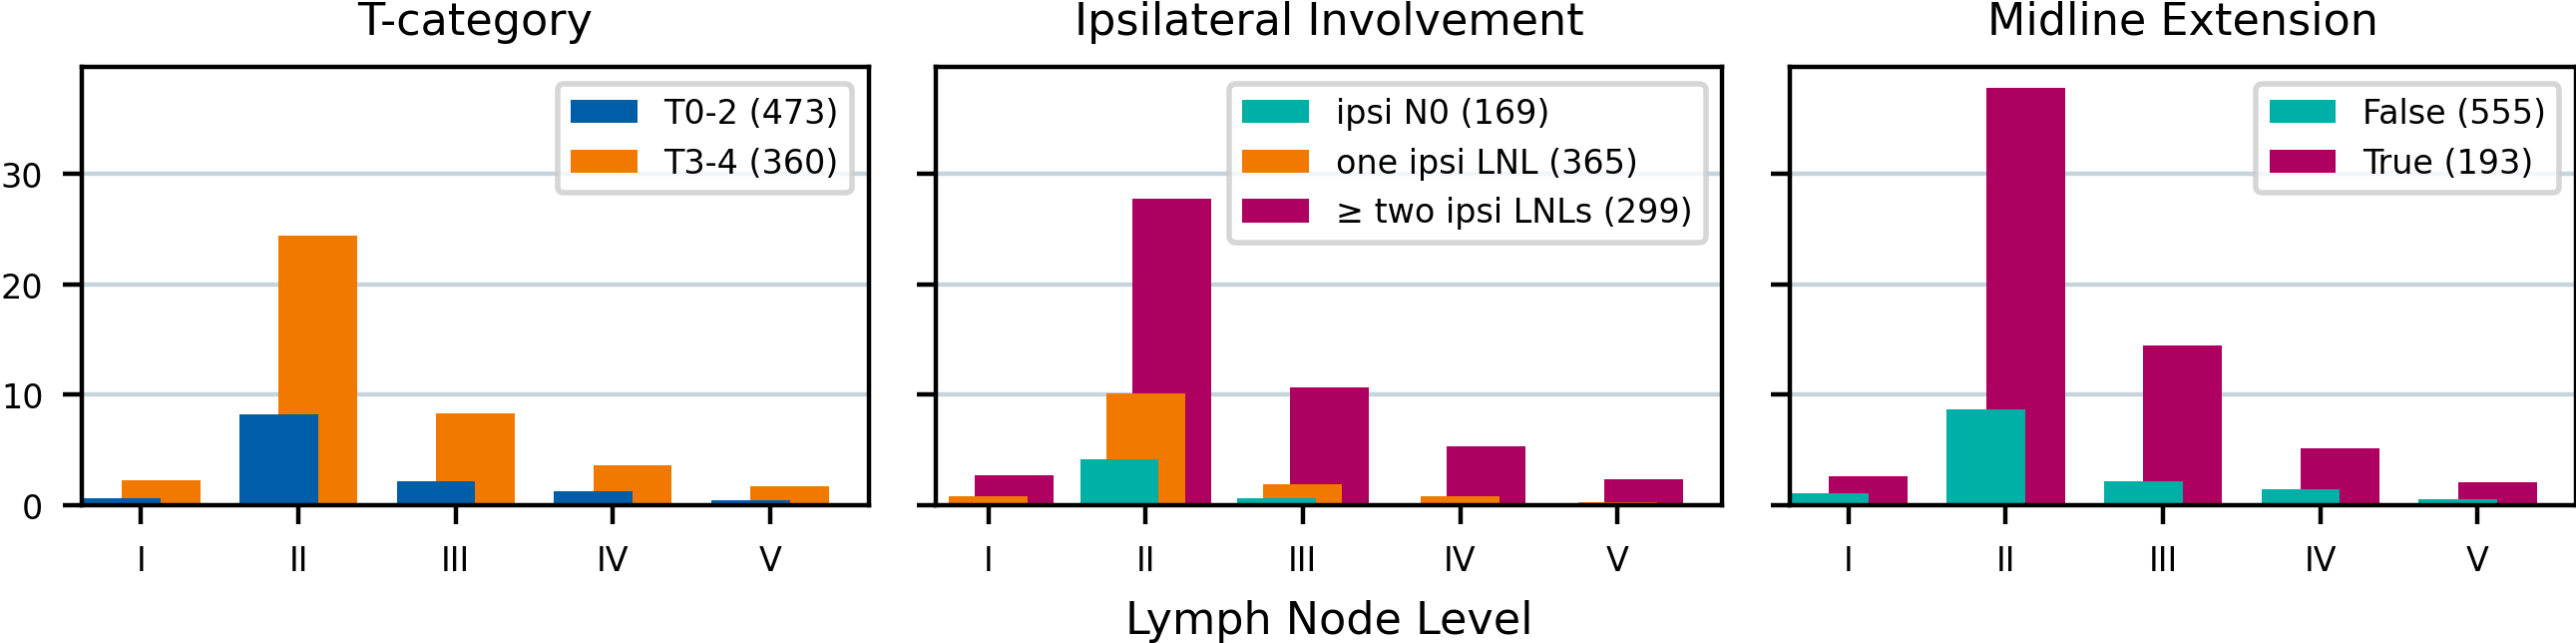
<figcaption>Figure 1: Contralateral involvement stratified by T-category (left panel), the number of metastatic LNLs ipsilaterally (center panel), and whether the primary tumor extended over the mid-sagittal line or was clearly lateralized (right panel).</figcaption>
</figure>

The left panel in <a href="#fig-data-strat" class="quarto-xref">figure 1</a> indicates that T-category is correlated with contralateral involvement (as it is with overal involvement). This is simply because T-category may on average be considered a surrogate for the time between onset of disease and diagnosis. I.e., a patient with a T4 tumor was – on average – diagnosed later than a patient with a T1 tumor. Thus, the former did have more time to develop metastases.

Similarly, ipsilateral involvement correlates with contralateral metastasis. The tumor of a patients with many metastases in ipsilateral LNLs was probably able to spread for longer (or faster) compared to a tumor in a patient with no nodal disease. This, too, may therefore be considered a surrogate for the duration of the disease. In rare cases, bulky nodal disease ipsilaterally may also redirect lymph fluids to the contralateral side. <!-- citation needed? -->

Lastly, the right panel in <a href="#fig-data-strat" class="quarto-xref">figure 1</a> shows that patients with a tumor crossing the mid-sagittal line show contralateral involvement vastly more often compared to patients with clearly lateralized tumors. This makes intutitive sense, because the lymphatic system in the head and neck region is typically symmetric and thus no major vessels cross the midline. Therefore, interstitial fluids from the primary tumor – which we assume to carry living malignant cells – may only reach the blind-ended lymphatic vessels in the contralateral neck via short-ranged diffusion. Which in turn is only possible when the primary tumor is close enough to the mid-sagittal line or crosses it. <!-- citation(s) needed? or is this intuition good enough? -->

## Requirements for a Bilateral Model

Based on the observations of the [previous section](#sec-data-strat), any potential model that aims to also predict the risk for contralateral nodal involvement, should be able to take the following into account:

1.  More advanced T-category should lead to higher risk for nodal disease. One approach to achieve this via the expected time of diagnosis has already been developed in the form of a hidden Markov model ([Ludwig et al. 2021](#ref-ludwig_hidden_2021)).
2.  The degree of ipsilateral involvement should give the model information on the time that may have passed between onset and diagnosis of the disease. This should come in addition to what can be inferred about this time from T-category alone.
3.  A tumor that extends over the mid-sagittal line should yield contralateral metastases with much higher probability.

Over the course of this work, we will first briefly recap the mentioned HMM in <a href="#sec-unilateral" class="quarto-xref">section 3</a>, which was so far used to model ipsilateral lymphatic progression only. Then, we intuitively extend it to include the contralateral side as well in <a href="#sec-ext-to-contra" class="quarto-xref">section 4</a>. In this section, we also introduce a way of modelling the tumor’s midline extension as a random variable (<a href="#sec-midline" class="quarto-xref">section 4.1</a>) and lastly talk about how it may affect the contralateral spread in <a href="#sec-params-symmetry" class="quarto-xref">section 4.2</a>.

<!-- TODO: Hint at methods and results... -->

## Data Availability

The entire data, including additional patients with tumors in other primary locations than the oropharynx, is publicly available: It may be [downloaded from LyProX](https://lyprox.org/patients/dataset) where it can be interactively explored too, [from GitHub](https://github.com/rmnldwg/lydata), [from zenodo](https://zenodo.org/search?q=lydata), or via the *Data-in-Brief* publications Ludwig et al. ([2022](#ref-ludwig_dataset_2022)) and Ludwig, Schubert, Barbatei, Bauwens, Werlen, et al. ([2023](#ref-ludwig_multicentric_2023)). Although these publications do not include the most recent dataset addition from Vall d’Hebron Barcelona Hospital.

# Unilateral Model for Lymphatic Progression

<figure id="fig-small-graph">
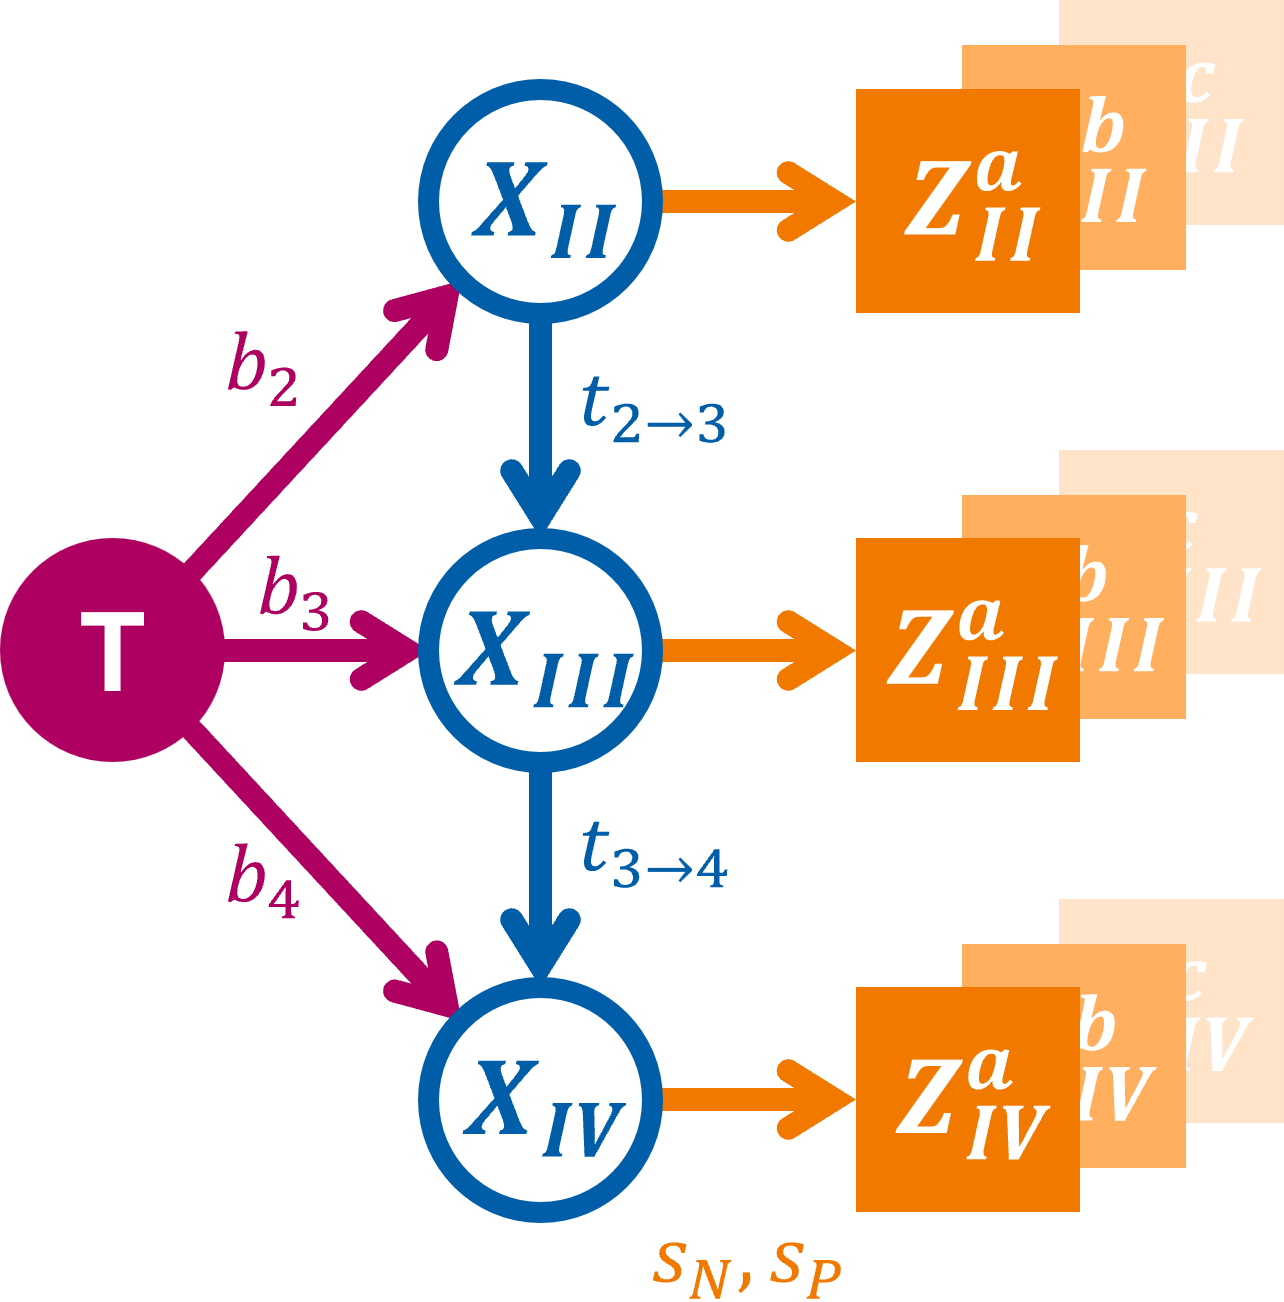
<figcaption>Figure 2: Directed acyclic graph (DAG) representing the abstract lymphatic network in the head and neck region. Blue nodes are the LNLs’ hidden random variables, the red node represents the tumor, and the orange square nodes depict the binary observed variables. Red and blue arcs symbolize the probability of lymphatic spread along that edge during one time-step. The orange arcs represent the sensitivity and specificity of the observational modality (e.g. CT, MRI, pathology, …).</figcaption>
</figure>

Our first model to predict the lymphatic progression of HNSCC was introduced using Bayesian networks ([Pouymayou et al. 2019](#ref-pouymayou_bayesian_2019)). We subsequently extended this work to a hidden Markov model (HMM) ([Ludwig et al. 2021](#ref-ludwig_hidden_2021)) to allow an intuitive inclusion of T-category into the predictions. We will briefly summarize this HMM’s formalism before building on it to include the contralateral spread in <a href="#sec-ext-to-contra" class="quarto-xref">section 4</a>.

We model a patient’s state of involvement at an abstract time-step $t$ as a vector of hidden binary random variables:

<span id="eq-state-def">$$
\mathbf{X}[t] = \begin{pmatrix} X_v[t] \end{pmatrix} \qquad v \in \left\{ 1, 2, \ldots, V \right\}
 \qquad(1)$$</span>

Here, $V$ is the number of LNLs the model considers. The values a LNL’s hidden binary RV may take on are $X_v[t] = 0$ (`False`), meaning the LNL $v$ is healthy or free of metastatic disease, or $X_v[t] = 1$ (`True`), corresponding to some for of tumor presence (i.e., occult or clinical).

Since the state vector $\mathbf{X}[t]$ is $V$-dimensional and binary, there are $2^V$ distinct possible lymphatic involvement patterns, which we enumerate from $\boldsymbol{\xi}_0 = \begin{pmatrix} 0 & 0 & \cdots & 0 \end{pmatrix}$ to $\boldsymbol{\xi}_{2^V} = \begin{pmatrix} 1 & 1 & \cdots & 1 \end{pmatrix}$.

Any hidden Markov model is fully described by three quantities:

1.  A starting state $\mathbf{X}[t=0]$ at time $t=0$ just before the patient’s tumor formed. In our case, this is always the state where all LNLs are still healthy $\boldsymbol{\xi}_0$.
2.  The *transition matrix* <span id="eq-trans-matrix">$$
    \mathbf{A} = \left( A_{ij} \right) = \big( P \left( \mathbf{X}[t+1] = \boldsymbol{\xi}_j \mid \mathbf{X}[t] = \boldsymbol{\xi}_i \right) \big)
     \qquad(2)$$</span> where the value at row $i$ and column $j$ represents the probability to transition from state $\boldsymbol{\xi}_i$ to $\boldsymbol{\xi}_j$ during the time-step from $t$ to $t+1$. Note that we prohibit self-healing, meaning that during a transition, no LNL may change their state from $X_v[t]=1$ to $X_v[t+1]=0$. This effectively masks large parts of the transition matrix to be zero.
3.  Lastly, the *observation matrix* <span id="eq-obs-matrix">$$
    \mathbf{B} = \left( B_{ij} \right) = \big( P \left( \mathbf{Z} = \boldsymbol{\zeta}_j \mid \mathbf{X}[t_D] = \boldsymbol{\xi}_i \right) \big)
     \qquad(3)$$</span> where in row $i$ and at column $j$ we find the probability to *observe* a lymphatic involvement pattern $\mathbf{Z} = \boldsymbol{\zeta}_j$, given that the true (but hidden) state of involvement at the time of diagnosis $t_D$ is $\mathbf{X}[t_D] = \boldsymbol{\xi}_i$.

Note that the transition matrix $\mathbf{A}$ is parametrized using the spread probabilities of a directed acyclic graph (DAG) that we define as the underlying mechanistic representation of the lymphatic network. An example of such a DAG is shown in <a href="#fig-small-graph" class="quarto-xref">figure 2</a>.

Using the introduced quantities, we can evolve the distribution of all possible hidden states from $\mathbf{X}[t=0] = \boldsymbol{\xi}_0$ step by step, by successively multiplying this vector with the transition matrix $\mathbf{A}$. At the time of the diagnosis $t_D$, we multiply the result with the observation matrix $\mathbf{B}$. We may then look up the likelihood of a patient presenting with the diagnosis $\mathbf{Z}=\boldsymbol{\zeta}_i$ in the $i$-th entry of the final result.

However, the remaining issue is that the value of $t_D$ is unknown, i.e. over how many time-steps the HMM should be evolved. We solve this problem by marginalizing over the time of diagnosis. Different distributions over the diagnosis times can then be choosen based on T-category. For instance, the mean of the time-prior to marginalize over the diagnosis time for early T-category patients $P\left( t_D \mid \text{early} \right)$ may be shifted towards earlier times than the one for advanced T-category patients $P\left( t_D \mid \text{early} \right)$. This gives us for example

$$
P\left( \mathbf{X} \mid \text{T}x = \text{early} \right) = \sum_{t=0}^{t_\text{max}} P \left( \mathbf{X} \mid t \right) \cdot P(t \mid \text{early})
$$

For later use, we define at this point the matrices $\boldsymbol{\Lambda}$:

<span id="eq-lambda-matrix">$$
\boldsymbol{\Lambda} = P \left( \mathbf{X} \mid \mathbf{t} \right) = \begin{pmatrix}
\boldsymbol{\pi}^\intercal \cdot \mathbf{A}^0 \\
\boldsymbol{\pi}^\intercal \cdot \mathbf{A}^1 \\
\vdots \\
\boldsymbol{\pi}^\intercal \cdot \mathbf{A}^{t_\text{max}} \\
\end{pmatrix}
 \qquad(4)$$</span>

Where the $k$-th row in this matrix corresponds to the distribution over hidden states after $t=k-1$ time-steps.

In this work, we use binomial distributions $\mathfrak{B} \left( t_D, p_{\text{T}x} \right)$ as time-priors which have one free parameter $p_{\text{T}x}$ for each group of patients we differentiate based on T-category. Also, we fix $t_\text{max} = 10$, which means that the expected number of time-steps from the onset of a patient’s disease to their diagnosis is $\mathbb{E}\left[ t_D \right] = 10 \cdot p_{\text{T}x}$.

## Likelihood Function

With the formalism introduced above, we can write the likelihood function for a patient to present with a diagnosis consisting of an observed state and a T-category $d = \left( \boldsymbol{\zeta}_i, \text{T}x \right)$ as follows:

<span id="eq-single-patient-llh">$$
\ell = P \left( \mathbf{Z} = \boldsymbol{\zeta}_i \mid \text{T}x \right) = \sum_{t=0}^{t_\text{max}} \left[ \boldsymbol{\xi}_0 \cdot \mathbf{A} \cdot \mathbf{B} \right]_i \cdot P \left( t \mid \text{T}x \right)
 \qquad(5)$$</span>

Above, the quantity inside $\left[ \ldots \right]_i$ denotes the $i$-th component of the vector that is the result of the vector and matrix multiplications in the square brackets. Note that it is also possible to account for missing involvement information: If a diagnosis (like fine needle aspiration (FNA)) is only available for a subset of all LNLs, we can sum over all those possible complete observed states $\boldsymbol{\zeta}_j$ that match the provided diagnosis.

The single-patient likelihood $\ell$ in <a href="#eq-single-patient-llh" class="quarto-xref">equation 5</a> depends on the spread parameters shown in <a href="#fig-small-graph" class="quarto-xref">figure 2</a> via the transition matrix $\mathbf{A}$ and on the binomial parameters $p_{\text{T}x}$ via time-priors. In this work, we will only differentiate between “early” (T1 & T2) and “advanced” (T3 & T4) T-categories. Therefore, our parameter space is:

<span id="eq-param-space">$$
\boldsymbol{\theta} = \left( \left\{ b_v \right\}, \left\{ t_{vr} \right\}, p_\text{early}, p_\text{adv.} \right) \quad \text{with} \quad \genfrac{}{}{0pt}{2}{v\leq V}{r\in\operatorname{pa}(v)}
 \qquad(6)$$</span>

And it is our goal to infer the values of these parameters for a given dataset $\mathcal{D} = \left( d_1, d_2, \ldots, d_N \right)$ of OPSCC patients. The likelihood of these $N$ diagnoses is simply the product of their individual likelihoods as defined in <a href="#eq-single-patient-llh" class="quarto-xref">equation 5</a>. For numerical reasons, we typically compute the data likelihood in log space:

<span id="eq-log-likelihood">$$
\log \mathcal{L} \left( \mathcal{D} \mid \boldsymbol{\theta} \right) = \sum_{i=1}^N \log \ell_i
 \qquad(7)$$</span>

The methodology we use to infer the model’s parameters is detailed in <a href="#sec-sampling" class="quarto-xref">section 5.2</a>.

## Model Prediction in the Bayesian Context

Our stated goal is to compute the risk for a patient’s true nodal involvement state $\mathbf{X}$, *given* their individual diagnosis $d = \left( \boldsymbol{\zeta}_k, \text{T}x \right)$. Using Bayes’ law, this is written as:

<span id="eq-uni-bayes-law">$$
P \big( \mathbf{X} \mid \mathbf{Z}=\boldsymbol{\zeta}_k, \boldsymbol{\hat{\theta}}, \text{T}x \big) = \frac{P \left( \boldsymbol{\zeta}_k \mid \mathbf{X} \right) P \big( \mathbf{X} \mid \boldsymbol{\hat{\theta}}, \text{T}x \big)}{\sum_{i=0}^{2^V} P \left( \boldsymbol{\zeta}_k \mid \mathbf{X}=\boldsymbol{\xi}_i \right) P \big( \mathbf{X}=\boldsymbol{\xi}_i \mid \boldsymbol{\hat{\theta}}, \text{T}x \big)}
 \qquad(8)$$</span>

The term $P \left( \boldsymbol{\zeta}_k \mid \mathbf{X} \right)$ is defined solely by sensitivity and specificity of the diagnostic modality. Terms like this already appeared in the definition of the observation matrx in <a href="#eq-obs-matrix" class="quarto-xref">equation 3</a>. The *prior* $P \big( \mathbf{X} \mid \boldsymbol{\hat{\theta}} \big)$ in the above equation is the crucial term that is supplied by a trained model and its parameters $\boldsymbol{\hat{\theta}}$.

It is possible to compute this *posterior* probability of true involvement not only for one fully defined state $\mathbf{X}$, but also for e.g. individual LNLs: For example, the risk for involvement in level IV would be a marginalization over all states $\boldsymbol{\xi}_i$, where $\xi_{i4}=1$. Formally:

<span id="eq-marg-over-posterior">$$
P \big( \text{IV} \mid \mathbf{Z}=\boldsymbol{\zeta}_k, \boldsymbol{\hat{\theta}}, \text{T}x  \big) = \sum_{k \, : \, \xi_{k4}=1} P \big( \mathbf{X} = \boldsymbol{\xi}_k \mid \boldsymbol{\zeta}_k, \boldsymbol{\hat{\theta}}, \text{T}x  \big)
 \qquad(9)$$</span>

# Extension to a Bilateral Model

A naive approach to model the contralateral lymphatic spread would be to simply employ two independent unilateral models as introduced in <a href="#sec-unilateral" class="quarto-xref">section 3</a>. During training, one could even enforce some shared parameters between these two models, like the parameterization of the distributions over diagnose times or the spread among the LNLs. Additionally, we could think of an approach to incorporate the primary tumor’s mid-sagittal extension as a risk factor.

However, this approach lacks a way to describe the correlation between ipsi- and contralateral involvement. This is displayed in <a href="#tbl-data-strat" class="quarto-xref">table 3</a> and shows how often the contralateral LNLs I, II, III, and IV were involved, given all possible combinations of midline extension, T-category, and ipsilateral LNL III involvement. Unsurprisingly, the prevalence for contralateral involvement is consistently higher when the tumor extends over the mid-sagittal line or is of later T-category. But it is also more frequent when the ipsilateral side shows more severe involvement, which is here shown via the surrogate LNL III.

Thus, we attempt to extend the formalism in <a href="#sec-unilateral" class="quarto-xref">section 3</a> in such a way that the model’s ipsi- and contralateral side evolve synchronously. To achieve that, we start by writing down the posterior distribution of involvement an analogy to <a href="#eq-uni-bayes-law" class="quarto-xref">equation 8</a>, which is now a joint probability of an involvement $\mathbf{X}^\text{i}$ ipsilaterally *and* an involvement $\mathbf{X}^\text{c}$ contralaterally, given a diagnosis of the ipsilateral LNLs $\mathbf{Z}^\text{i}$ and of the contralateral ones $\mathbf{Z}^\text{c}$:

<span id="eq-bilateral-bayes">$$
P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \mid \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c} \right) = \frac{P \left( \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c} \mid \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \right) P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \right)}{P \left( \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c} \right)}
 \qquad(10)$$</span>

For the sake of brevity, we omit the dependency on the parameters and the T-category here.

The likelihood of the diagnoses given a hidden state simply factorise: $P \left( \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c} \mid \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \right) = P \left( \mathbf{Z}^\text{i} \mid \mathbf{X}^\text{i} \right) \cdot P \left( \mathbf{Z}^\text{c} \mid \mathbf{X}^\text{c} \right)$. And the two factors are contained in the observation matrices $\mathbf{B}^\text{i}$ and $\mathbf{B}^\text{c}$.

The term representing the model’s prior probability of hidden involvement does not factorize. However, if we assume that lymphatic spread typically does not cross the mid-sagittal line, we can write it as a factorising sum:

<span id="eq-bilateral-marginal">$$
\begin{aligned}
P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \right) &= \sum_{t=0}^{t_\text{max}} P(t) \cdot P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \mid t \right) \\
&= \sum_{t=0}^{t_\text{max}} P(t) \cdot P \left( \mathbf{X}^\text{i} \mid t \right) \cdot P \left( \mathbf{X}^\text{c} \mid t \right)
\end{aligned}
 \qquad(11)$$</span>

This assumption makes intuitive sense: The two sides of the lymphatic network in a typical patient are approximately mirror images of each other. Thus, no major vessels cross the mid-sagittal line. There may, however, be diffusion of lymph fluid accross this line or bulky involvement that redirects lymphatic drainage significantly.

Using this assumption along with <a href="#eq-lambda-matrix" class="quarto-xref">equation 4</a>, we can write the above distribution algebraically as a product:

<span id="eq-bilateral-marginal-algebra">$$
P \left( \mathbf{X}^\text{i} = \boldsymbol{\xi}_n, \mathbf{X}^\text{c} = \boldsymbol{\xi}_m \right) = \left[ \boldsymbol{\Lambda}^\intercal_\text{i} \cdot \operatorname{diag} P(\mathbf{t}) \cdot \boldsymbol{\Lambda}_\text{c} \right]_{n,m}
 \qquad(12)$$</span>

## Modelling Midline Extension

To account for the increased prevalence of involvement on the contralateral side when the tumor is not clearly lateralized anymore, we also model the tumor’s extension over the mid-sagittal line as a binary random variable. It starts lateralized and at every time-step there is a finite probability $p_\epsilon$ that the tumor grows over the symmetry plane of the patient.

Technically, the introduction of this additional random variable doubles the space of the hidden states and therefore quadruples the size of the transition matrix $\mathbf{A}$. However, since we assume no correlation between the tumor’s lateralization and the metastases in the LNLs, we can evolve the two parts separately.

The probabilities to find a patient with a clearly lateralized tumor or one that extends over the mid-sagittal line after $t$ time-steps are then given by

$$
\begin{aligned}
P(\epsilon = \texttt{False} \mid t) &= (1 - p_\epsilon)^t \\
P(\epsilon = \texttt{True} \mid t) &= 1 - P(\epsilon = \texttt{False} \mid t)
\end{aligned}
$$

In <a href="#fig-model-midext-evo" class="quarto-xref">figure 3</a>, we visualize how the prior distribution over diagnose times $P(t)$, the conditional probability of midline extension $P(\epsilon \mid t)$, and their joint $P(\epsilon, t)$ evolve over the course of a patient evolution.

<figure id="fig-model-midext-evo">
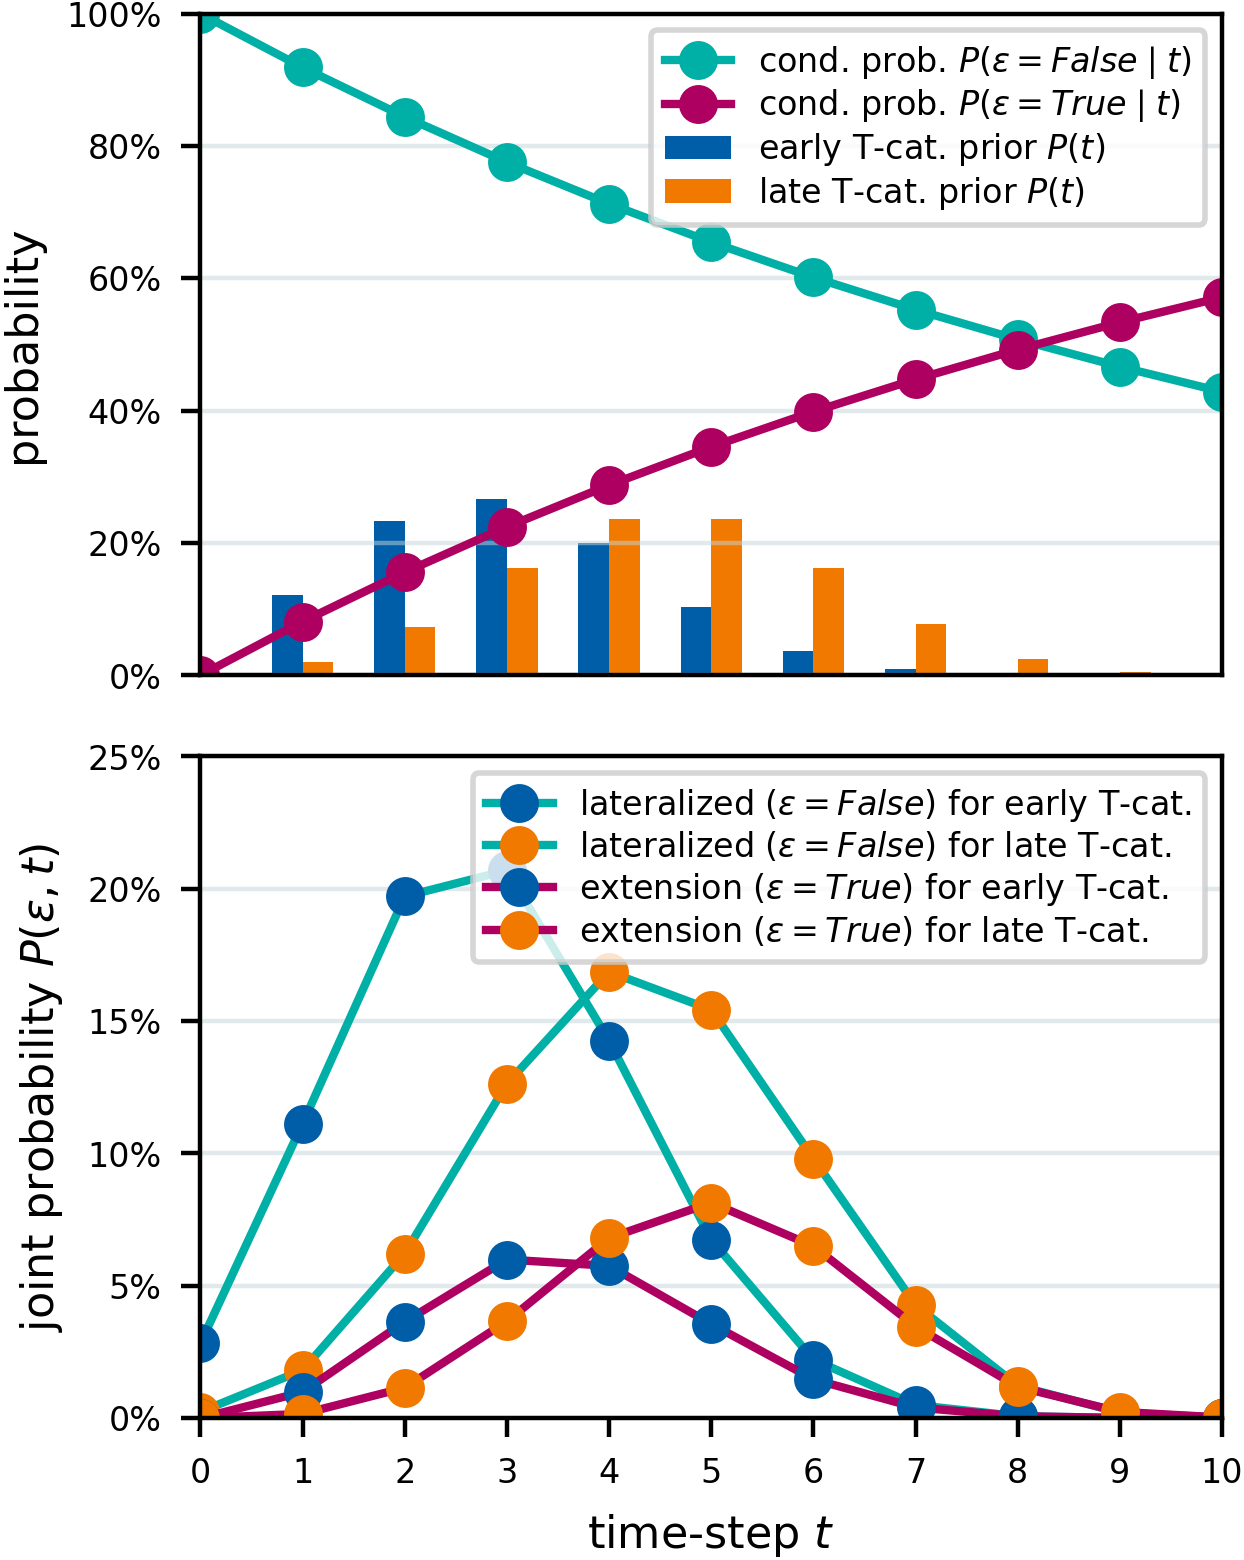
<figcaption>Figure 3: The top panel shows the prior probability to get diagnosed at time-step <span class="math inline">\(t\)</span> for early and late T-category tumors as bars. Also in the top panel, we plot the conditional probability of the tumor’s midline extension (<span class="math inline">\(\epsilon=\texttt{True}\)</span>), given the time-step <span class="math inline">\(t\)</span> as a line plot. In the bottom panel, we show the joint probability of getting diagnosed in time-step <span class="math inline">\(t\)</span> <em>and</em> having a tumor that crosses the midline.</figcaption>
</figure>

To get the joint probability over the ipsi- and contralateral hidden states, as well as the state of the tumor’s midline extension $P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c}, \epsilon \right)$, we simply add the above terms to the marginalization in <a href="#eq-bilateral-marginal" class="quarto-xref">equation 11</a>:

$$
P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c}, \epsilon \right) = \sum_{t=0}^{t_\text{max}} P(t) \cdot P(\epsilon \mid t) \cdot P \left( \mathbf{X}^\text{i} \mid t \right) \cdot P \left( \mathbf{X}^\text{c} \mid t \right)
$$

Again, this can be written algebraically, by defining the vector $P(\mathbf{t}, \epsilon) = P(\mathbf{t}) \cdot P(\epsilon \mid \mathbf{t})$, to achieve the same form as in <a href="#eq-bilateral-marginal-algebra" class="quarto-xref">equation 12</a>:

$$
P \left( \mathbf{X}^\text{i} = \boldsymbol{\xi}_n, \mathbf{X}^\text{c} = \boldsymbol{\xi}_m, \epsilon \right) = \left[ \boldsymbol{\Lambda}^\intercal_\text{i} \cdot \operatorname{diag} P(\mathbf{t}, \epsilon) \cdot \boldsymbol{\Lambda}_\text{c} \right]_{n,m}
$$

In <a href="#fig-model-state-dist" class="quarto-xref">figure 4</a> we plot the state distribution for a full midline model as two separate heatmaps. To keep it readable, this example model only considers the LNLs II, III, and IV ipsi- and contralaterally.

<figure id="fig-model-state-dist">
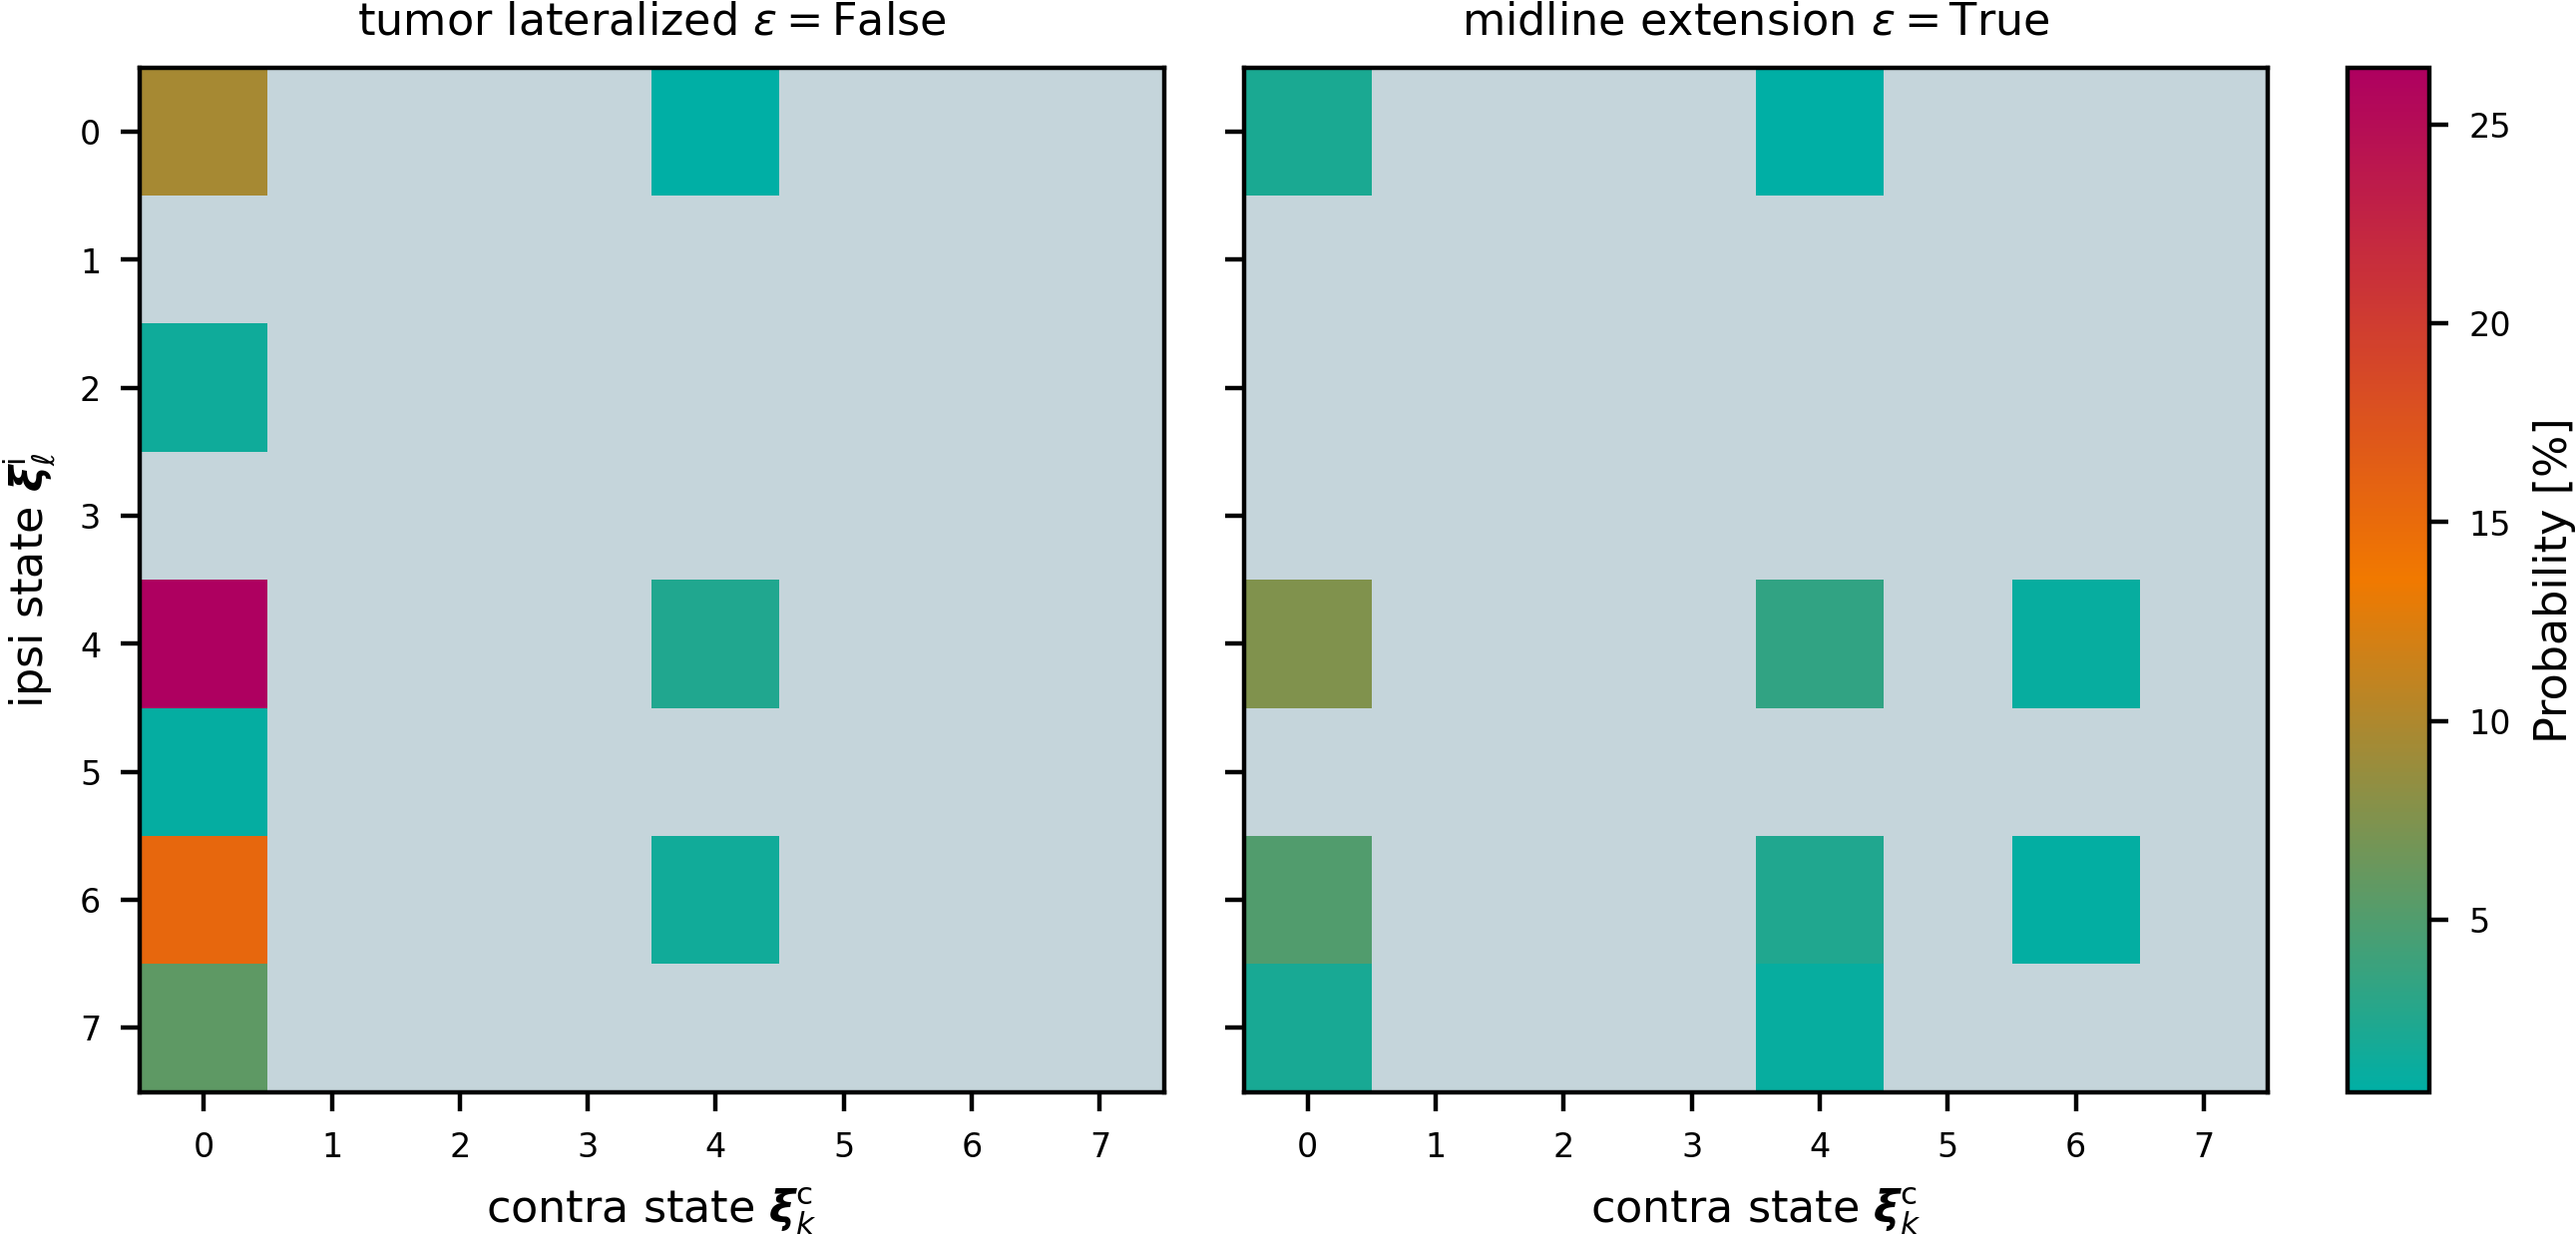
<figcaption>Figure 4: 3D state distribution of a midline model with 3 LNLs (II, III, and IV) in both sides of the neck.</figcaption>
</figure>

## Parameter Symmetries

In general, the matrices $\boldsymbol{\Lambda}_\text{i}$ and $\boldsymbol{\Lambda}_\text{c}$ could be parameterized using a disjoint set of parameters. I.e., the ipsi- and contralateral spread rates are entirely different. However, using two sensible assumptions, we can reduce the parameter space by sharing some parameters between the sides:

1.  We assume the spread *among* the LNLs to be same on both sides. It is reasonable to assume the lymphatic system is symmetric. Thus, the spread rates from one LNL to the other should be symmetric, too. Formally, this means  
    <span id="eq-symmetries">$$
    \begin{aligned}
    b_v^\text{c} &\neq b_v^\text{i} \\
    t_{rv}^\text{c} &= t_{rv}^\text{i}
    \end{aligned}
     \qquad(13)$$</span> for all $v \leq V$ and $r \in \operatorname{pa}(v)$.
2.  The tumor’s spread to the contralateral side in case of an extension over the midline is larger than if it was clearly lateralized, but smaller than its spread to the ipsilateral side. This assumption stems from a simple thought experiment: Consider moving the tumor from a clearly lateralized position accross the mid-sagittal plane to the same position, but on the contralateral side. In the beginning we would have $b_v^\text{c} < b_v^\text{i}$, while in the end, the situation is reversed. If a tumor extends over the mid-sagittal line, its contralateral spread rate can be expected to be in between these two extremes. We encode this in a *mixing parameter* $\alpha$ that captures a “degree of asymmetry”:  
    <span id="eq-mixing">$$
    b_v^{\text{c},\epsilon=\texttt{True}} = \alpha \cdot b_v^\text{i} + (1 - \alpha) \cdot b_v^{\text{c},\epsilon=\texttt{False}}
     \qquad(14)$$</span> This means the model now uses three different sets of parameters to describe the spread from the tumor to the LNLs: $b^\text{i}_v$ for the spread to the ipsilateral LNLs, $b_v^{\text{c},\epsilon=\texttt{False}}$ for the spread to the contralateral LNLs as long as the tumor is clearly lateralized, and finally $b_v^{\text{c},\epsilon=\texttt{True}}$ when it crosses the midline. Note, however, that these three sets of spread rates only account for $2 \cdot 2^V + 1$ parameters, since they are coupled via the mixing parameter $\alpha$.

Together with the explicit modelling of the tumor’s midline extension $\epsilon$ from <a href="#sec-midline" class="quarto-xref">section 4.1</a>, we now have a model that may be capable of capturing the higher prevalence of contralateral involvment that comes with tumors extending over the mid-sagittal line.

# Methods

<!-- Maybe I should break this apart into separate chapters on data, sampling, etc. -->

In this section, we detail how the experiments were performed. Every figure, table, and result is fully reproducible via the GitHub repository [`rmnldwg/bilateral-paper`](https://github.com/rmnldwg/bilateral-paper). It also contains the raw manuscript and instructions on how to recreate all figures, tables, and the final document.

## Involvement Data Consensus

It is possible to provide our model with multiple different diagnostic modalities, each being characterized by different pairs of sensitivity and specificity. However, we instead chose to combine them into a single “consensus” diagnosis before parameter inference. We opted for this because the literature values of sensitivity and specificity ([De Bondt and Others 2007](#ref-debondt_detection_2007)) of imaging modalities like MRI and CT do not plausibly match some of our observations: In the USZ cohort, 78% of OPSCC patients where diagnosed with ipsilateral LNL II involvement via diagnostic imaging. This is virtually impossible with sensitivities around 80% and specificities lower than 100%.

Our pre-training consensus was formed by considering all reported diagnostic information for a particular patient and LNL. When conflicts arose, we computed the *most likely* true state of involvement using the literature sensitivity and specificity values ([De Bondt and Others 2007](#ref-debondt_detection_2007)).

## MCMC Sampling

For parameter inference, we used the Python package [`emcee`](https://emcee.readthedocs.io/en/stable/) ([Foreman-Mackey et al. 2013](#ref-foreman-mackey_emcee_2013)). It implements efficient MCMC sampling algorithms that employ multiple parallel samplers for affine invariance and better performance on multi-core CPUs. The [`emcee`](https://emcee.readthedocs.io/en/stable/) library was provided with the likelihood implemented by our [`lymph-model`](https://lymph-model.readthedocs.io/en/stable/) Python package.

For each dimension in the parameter space of the model, we initialized 12 of these parallel samplers, called “walkers”, with random values in the unit cube. Every time all of these walkers advanced 50 steps, the autocorrelation time of the chains was estimated. For short chains, this estimate is not trustworthy, but stabilizes for longer chains. We therefore considered a sampling to be converged when two criteria where met:

1.  The change in the autocorrelation time was less then 5.0e-2.
2.  The estimate of the autocorrelation dropped below $n$ / 50 where $n$ is the length of the chain up to that point.

All samples up to this convergence - called the *burn-in phase* - were discarded. We only kept another 10 samples after that, which were spaced 10 steps apart.

## Computing the Observed and Predicted Prevalence of Involvement Patterns

We want to assess the model’s capability to approximate the distribution of lymphatic involvement patterns seen in the data. To that end, we compare the prevalence of some invovlement patterns under selected scenarios with the model’s prediction for how often these involvements it expects to see, given these scenarios.

In this context, a “scenario” includes the patient’s T-category $\text{T}x$ and whether the patient’s tumor extended over the mid-sagittal line, i.e. $\epsilon=\texttt{True}$ or $\epsilon=\texttt{False}$.

An involvement pattern specifies for each ipsi- and contralateral LNL whether it is “healthy”, “involved”, or “masked”. If it is “masked”, we essentially state that we are not interested in the involvement of that LNL and the prevalence will be marginalized over this LNL’s involvement.

For example, we may be interested in the prevalence of contralateral LNL II involvement (i.e., contra LNL II “involved” and all other LNLs “masked”) under the scenario of early T-category (T0-T2) and no midline extension ($\epsilon=\texttt{False}$). To compute this prevalence in the data, we select all patients of this scenario (in our data, this amounts to 379<!-- TODO: dyamically compute this --> patients). Of those, 28<!-- TODO: dynamically compute this --> were found to harbor metastases in their contralateral LNL II. Therefore, the prevalence is 7%<!-- TODO: dynamically compute this -->.

When displaying this data prevalence, we often choose to draw a *beta posterior* over the “true” prevalence, hinting at the fact that our data merely represents a limited sample. The beta posterior follows from a uniform beta distribution as prior and a binomial likelihood for the number of patients with the involvement of interest, given the parameer for the “true” prevalence. The resulting distribution has its maximum at the observed prevalence, but in addition gives a visual intuition for the variance of of the observed quantity. I.e., when we observe 3 out of 10 events, the beta posterior is much wider than if we observe 300 out of 1000 for he same prevalence. It also allows us to check not only if the model is accurate, but also whether it reflects the uncertainty contained in the data.

Predicting the prevalence using our model amounts to computing the following probability:

$$
P \left( \text{II}^\text{c} \mid \epsilon=\texttt{False}, \text{T}x=\text{early} \right) = \frac{P \left( \text{II}^\text{c}, \epsilon=\texttt{False} \mid \text{T}x=\text{early} \right)}{P \left( \epsilon=\texttt{False} \mid \text{T}x=\text{early} \right)}
$$

In the enumator, we marginalize over all ipsi- and contralateral LNLs’ involvements, except for LNL II contralaterally. This is similar to the marginalization in <a href="#eq-marg-over-posterior" class="quarto-xref">equation 9</a>, although we are summing over different quantities. In the denominator, we can simply insert the joint distribution over midline extension and diagnose time $P \left( \epsilon, t \right)$ marginalized over $t$ using the early T-category’s time-prior.

Since we compare it to the data, which does not report true but only observed involvement – although pathologically investigated LNLs may be as close as possible to the ground truth – we do not consider posteriors of the form $P \left( \mathbf{X} \mid \mathbf{Z} \right)$ here. Instead, we compute probabilities of observed involvement $P \left( \mathbf{Z} \right)$, as in the likelihood <a href="#eq-single-patient-llh" class="quarto-xref">equation 5</a>.

When plotted, we usually display histograms over the model’s predictions. Each of their values was computed from a different parameter set drawn during MCMC sampling, effectively giving us a distribution over the prevalences. Ideally, the histograms approximate the location and width of the Beta posteriors when attempting to describe the data they were trained on.

Note that we decided to omit the y-axis ticks and labels in these figures over prevalences and risks. The y-axis in these plots measures the probability density and its numerical values are not intuitively interpretable. Instead, we occasionally use the freed space to label e.g. rows of subplots.

# Results

First, in <a href="#fig-model-burnin-history" class="quarto-xref">figure 5</a>, we verify the sampling converged successfully by inspecting two monitoring quantities: The autocorrelation time of the MCMC chain and the acceptance fractions of the parallel walkers.

<figure id="fig-model-burnin-history">
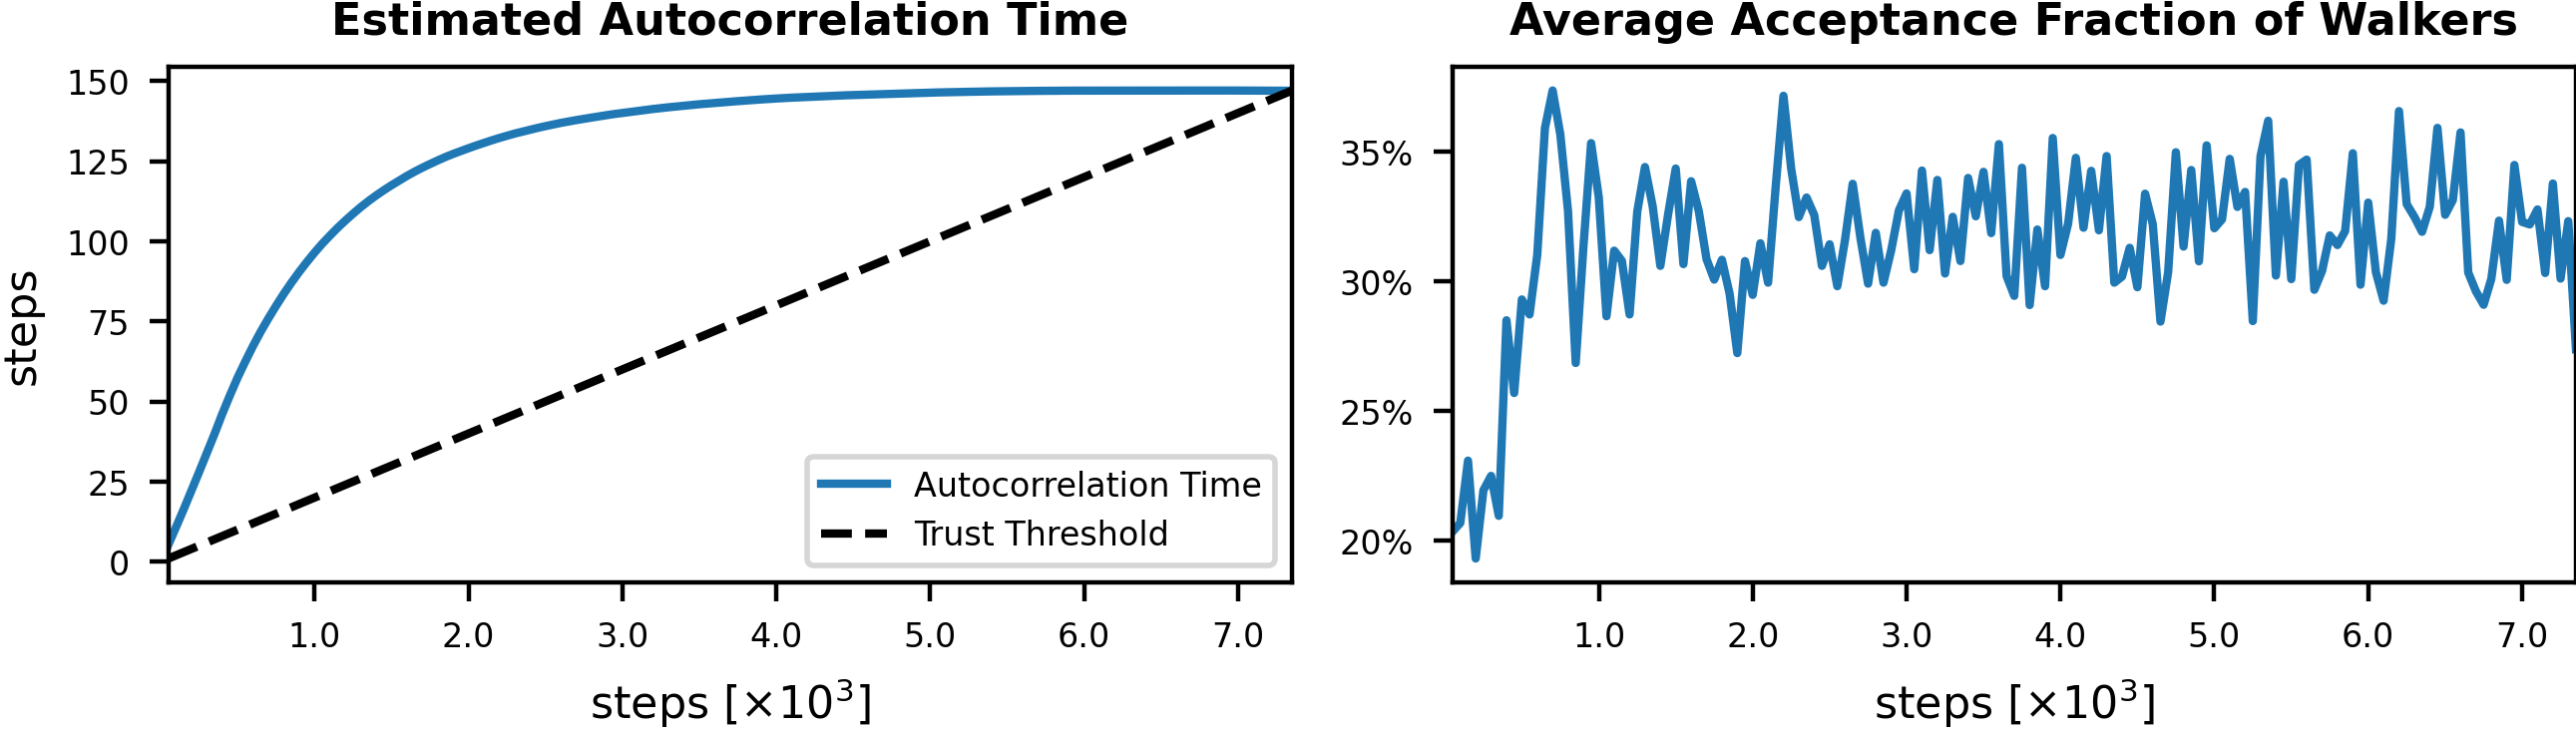
<figcaption>Figure 5: Monitoring quantities during the burn-in phase of the parameter sampling. Left: The autocorrelation time of the sampling chain estimated at different sampling steps. We consider the chain converged when the estimate of the autocorrelation time is stable and drops below the trust threshold of <span class="math inline">\(n/50\)</span> where <span class="math inline">\(n\)</span> is the number of steps. Right: Fraction of accepted MCMC proposals averaged over all parallel walkers. Values around 30% indicate good mixing of the walkers.</figcaption>
</figure>

In <a href="#tbl-midline-params" class="quarto-xref">table 2</a>, we tabulate the mean and standard deviation of the sampled parameters for the full midline model.

In [5]:
def map_param_names(name: str) -> str:
  """Make parameter names more readable."""
  try:
    return {
      "midext_prob": "Mid. ext. probability",
      "mixing": "Mixing ⍺",
      "late_p": "late T-cat. binom. prob.",
    }[name]
  except KeyError:
    return re.sub(
      r"(ipsi|contra)_", r"\g<1>: ", name
    ).replace(
      "to", " ➜ "
    ).replace(
      "_spread", ""
    )

model = shared.get_model(which="simple", load_samples=True)
samples = shared.get_samples(which="simple")

names = [map_param_names(p) for p in model.get_params()]
means, stds = samples.mean(axis=0), samples.std(axis=0)

early_midext_prob = model.state_dist(t_stage="early")[1].sum()
late_midext_prob = model.state_dist(t_stage="late")[1].sum()

params_table = pd.DataFrame({"Parameter": names, "Mean": means, "Std. Dev.": stds})
(
  params_table.style
  .format("{:.2%}", subset=["Mean"])
  .format("± {:.2%}", subset=["Std. Dev."])
  .apply(right_align, subset=["Mean", "Std. Dev."])
  .hide()
)

## Prevalence Predictions

We want to investigate whether and to what extent the model can fulfill the requirements laid out in <a href="#sec-requirements" class="quarto-xref">section 2.2</a>. To that end, we compare its predictions for contralateral involvement against observations in the data. This is done given scenarios that differ in T-category and/or midline extension and/or ipsilateral involvement.

### Dependence of Contralateral Involvement on T-Category and Midline Extension

In <a href="#fig-model-prevalences-overall" class="quarto-xref">figure 6</a>, we plot the prevalence of contralateral involvement of the LNLs II, III, and IV for the four scenarios made up of the possible combinations of early and late T-category, as well as lateralized and midline extending tumors.

<figure id="fig-model-prevalences-overall">
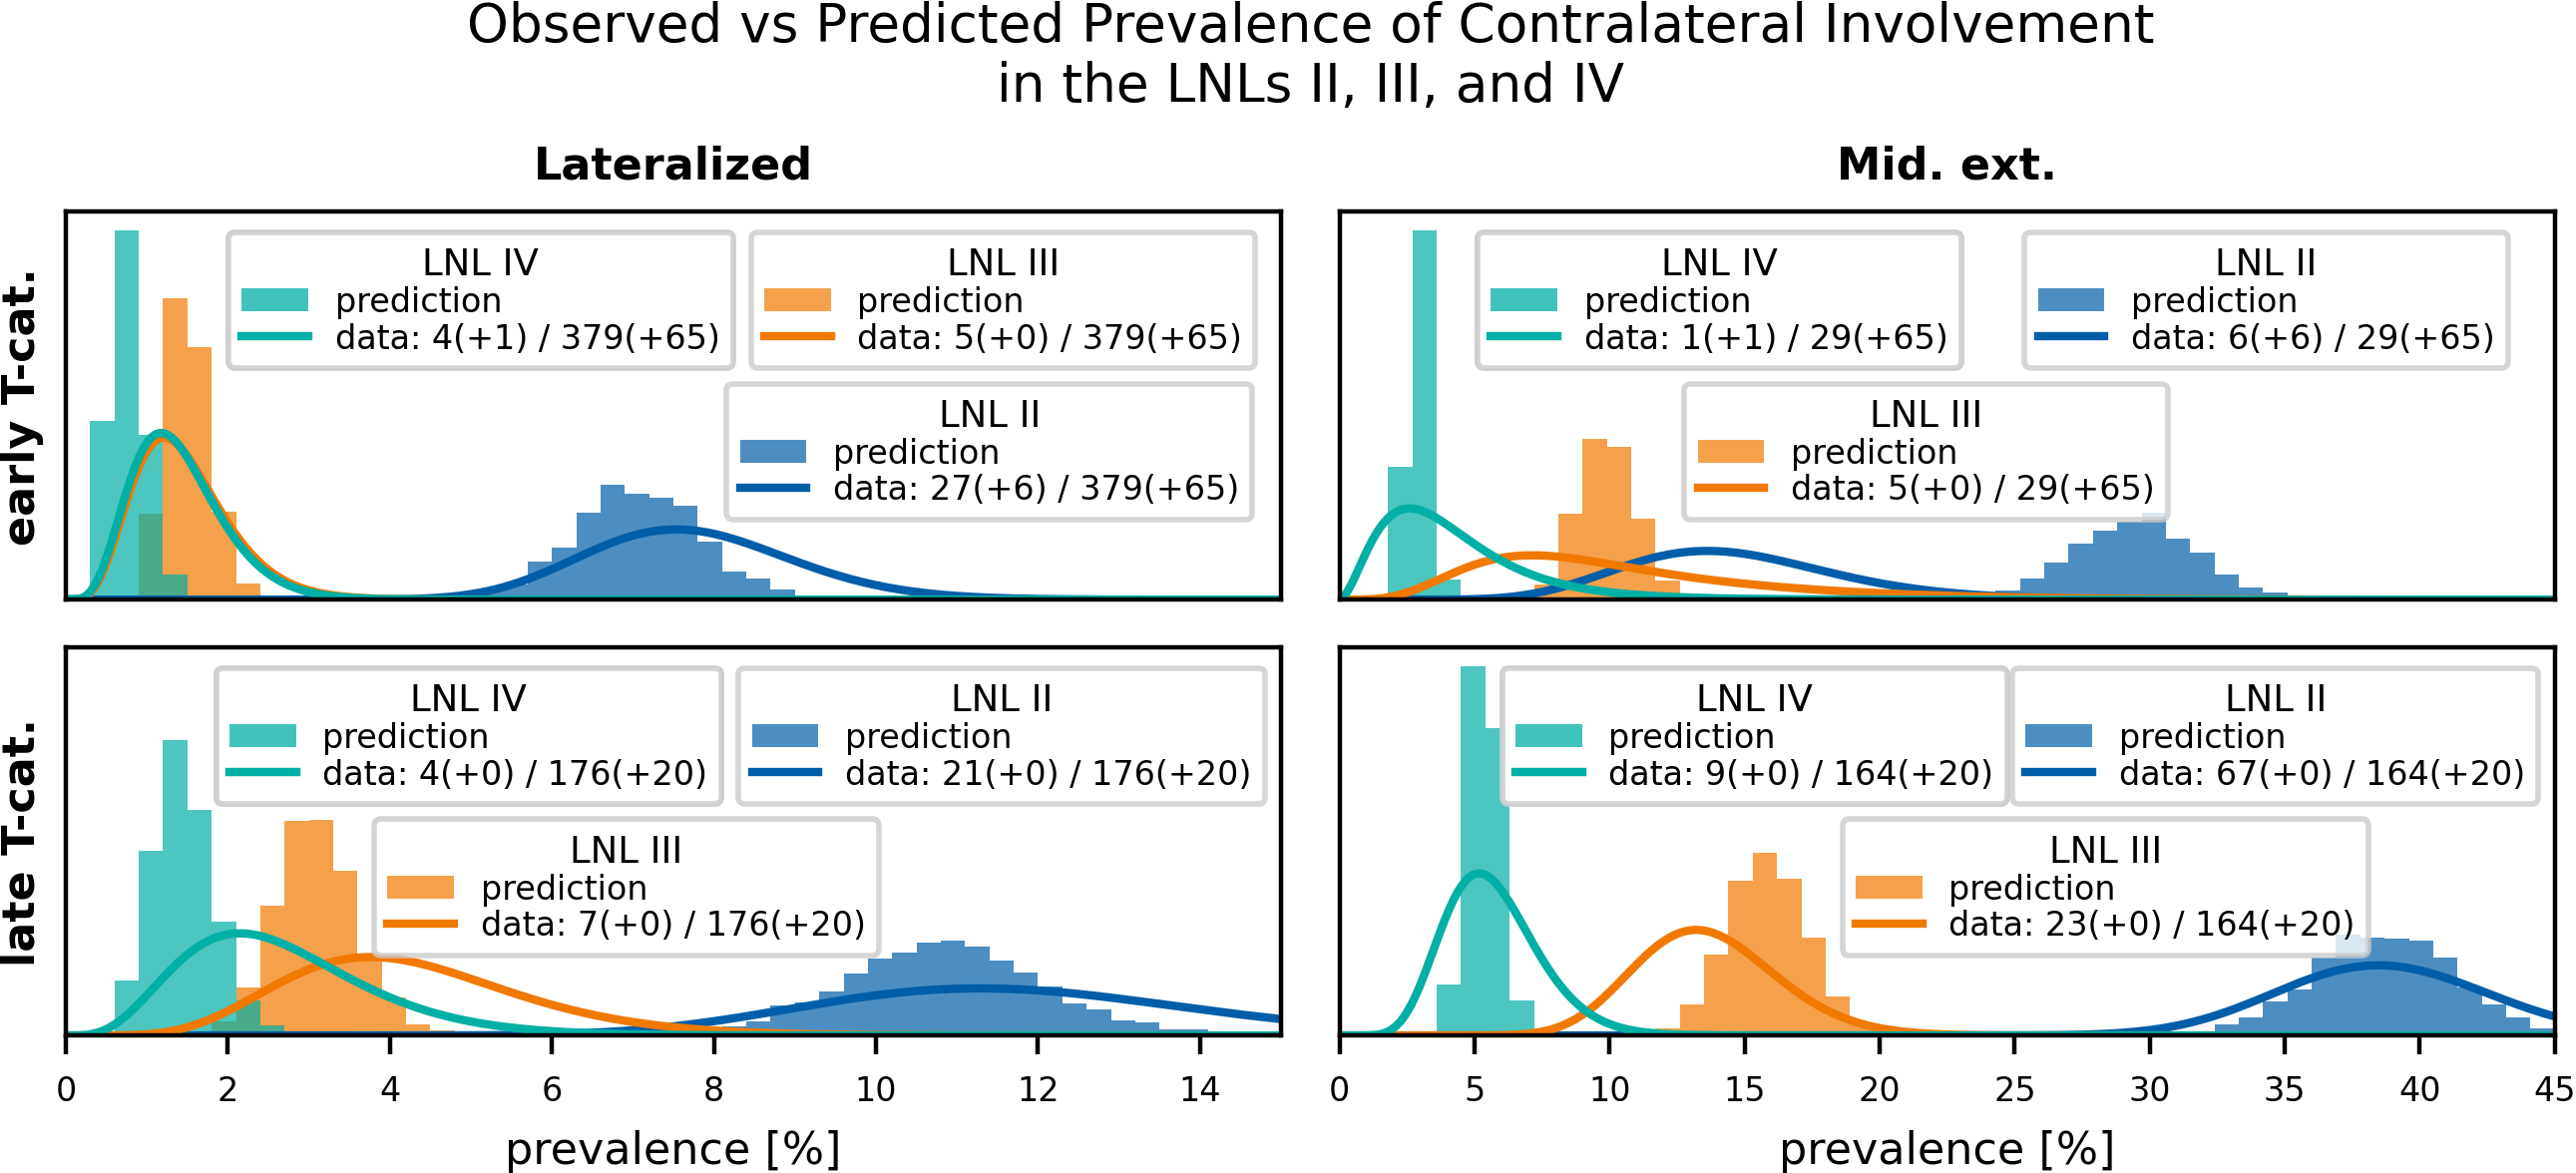
<figcaption>Figure 6: Comparison of predicted (histograms) vs observed (beta posteriors) prevalences. Shown for the contralateral LNLs II (blue), III (orange), and IV (green). The top row shows scenarios with early T-category tumors, the bottom row for late T-category ones. The left column depicts scenarios where the primary tumor is clearly lateralized, the right column scenarios of tumors extending over the mid-sagittal line. This figure illustrates the model’s ability to describe the prevalence of different combinations of scenarios involving the risk factors T-category and midline extension.</figcaption>
</figure>

<a href="#fig-model-prevalences-overall" class="quarto-xref">Figure 6</a> shows nicely how the model is capable of accurately taking the most important risk factors, i.e. T-category and midline extension, into account. As observed in the data, the model predicts that the prevalence of contralateral LNL II involvement jumps from below 8% <!-- TODO: make this dynamic --> for early T-category lateralized tumors to almost 40% <!-- TODO: make this dynamic --> when the tumor is of advanced T-category and crosses the mid-sagittal line.

However, for early T-category scenarios with midline extension, the model does seem to overestimate contralateral LNL II and III invovlement. This likely stems from the the small sample size of this relatively rare scenario as hinted at by the wide beta posteriors.

### Correlation between Ipsi- and Contralateral Involvement

<figure id="fig-model-prevalences-with-ipsi">
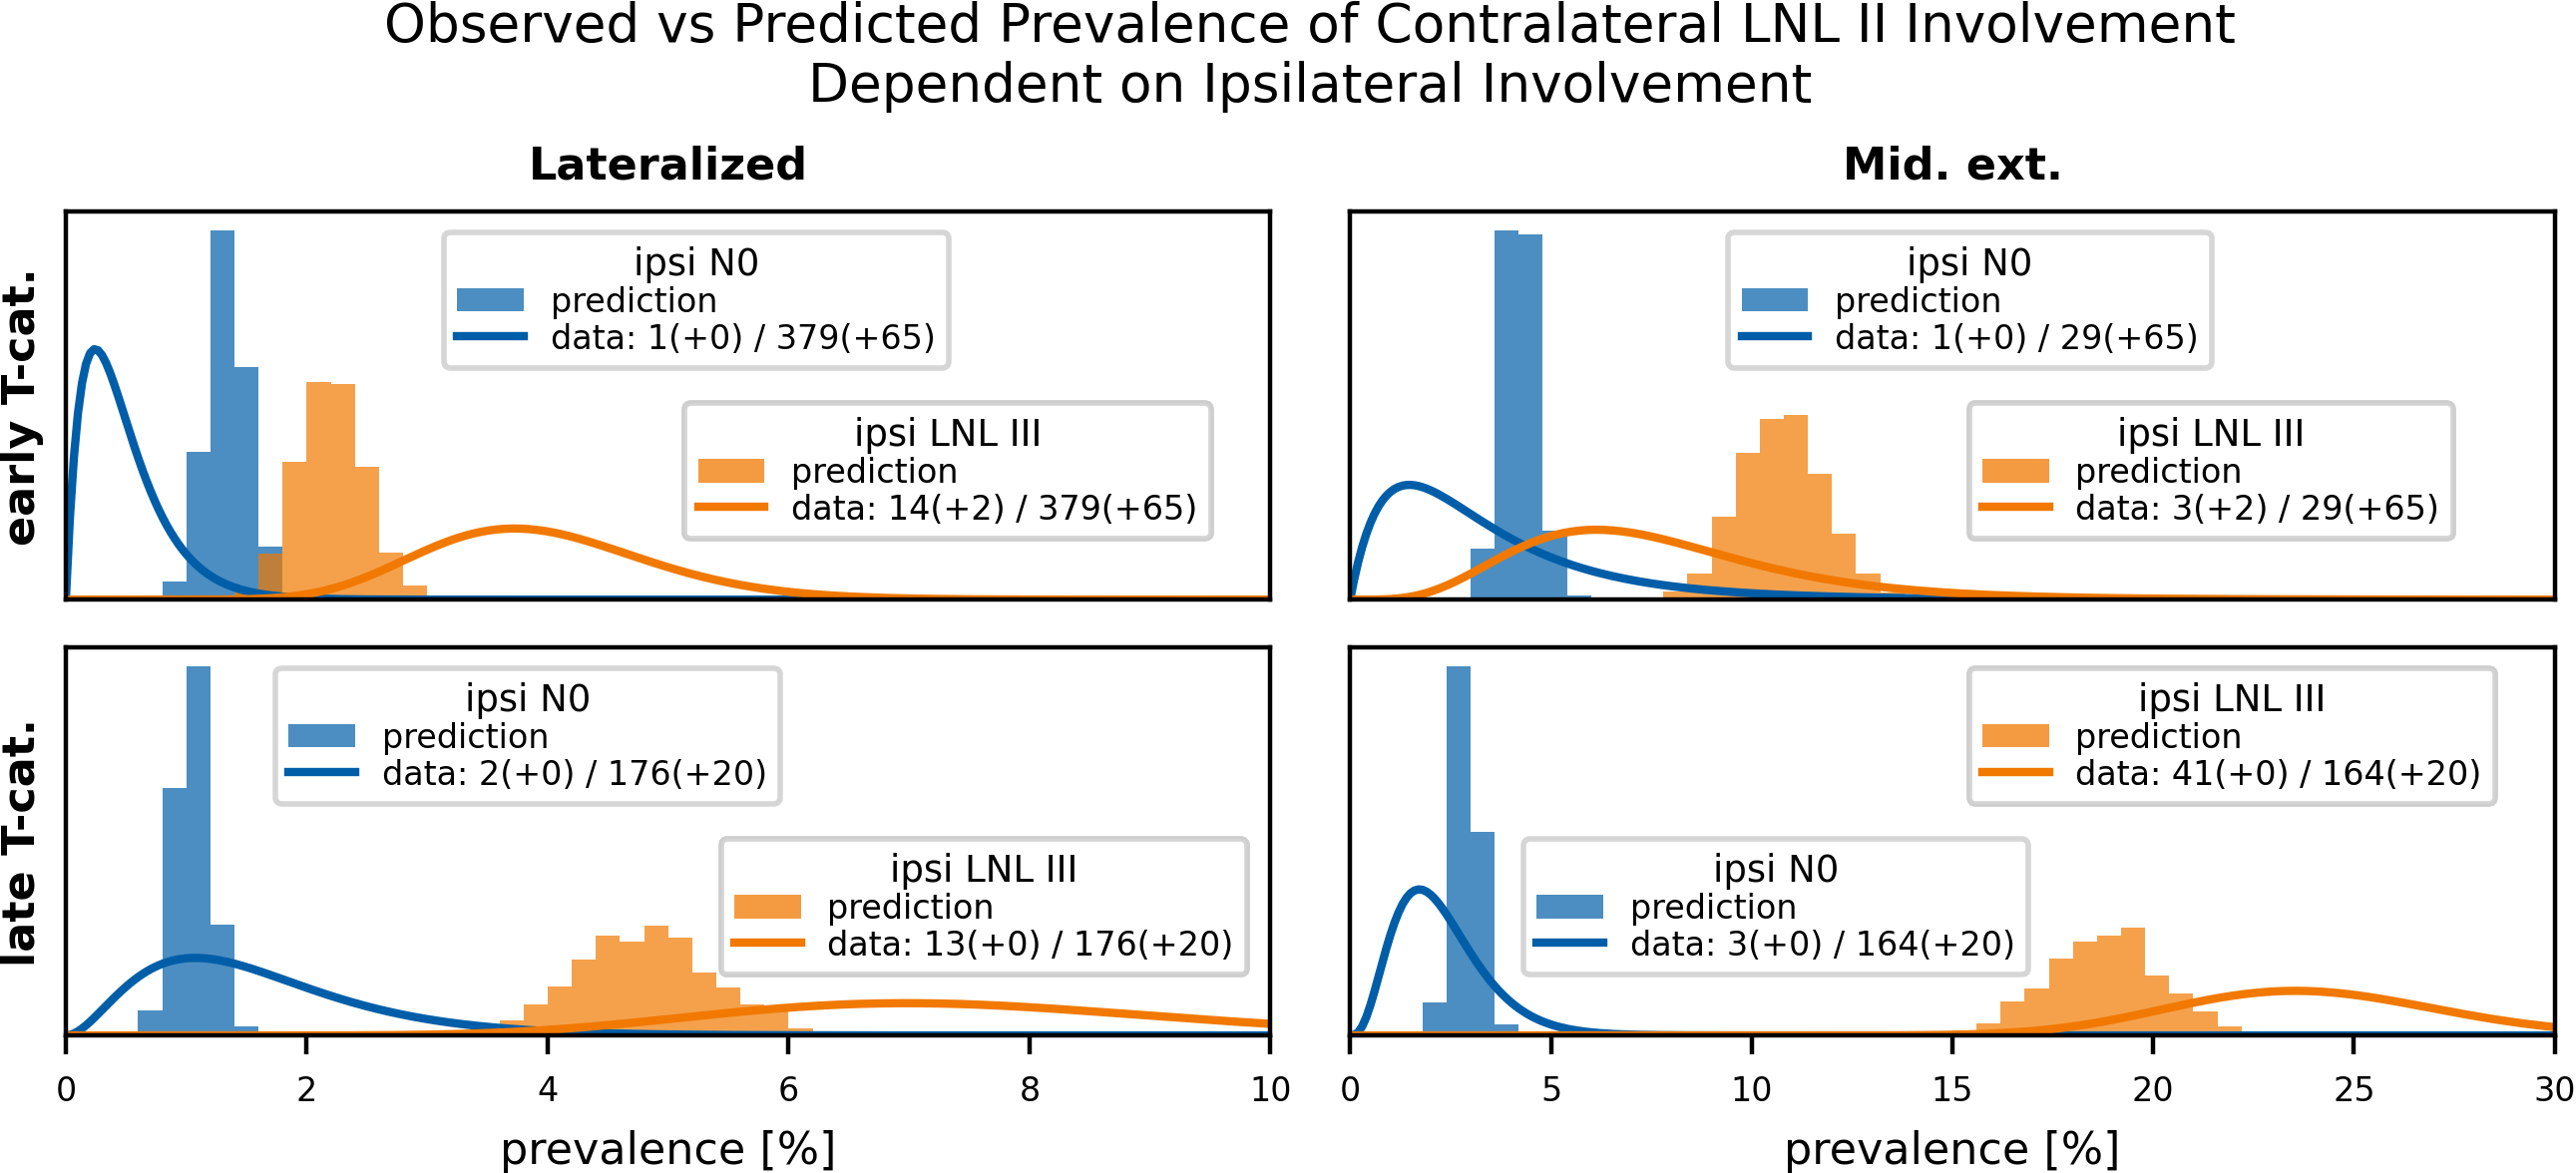
<figcaption>Figure 7: Comparison of predicted (histograms) vs observed (beta posteriors) prevalences. Shown are four scenarios, all including contralateral LNL II involvement: Early T-category and an ipsilateral N0 neck (green), early T-category and ipsilateral LNL II involvement (blue), as well as the same two scenarios but for advanced T-category (orange and red). The figure shows that the model is capable of describing the correlation between ipsi- and contralateral involvement. Although for the scenario of LNL II involvement in both sides, the prediction’s split between early and advanced T-category is not large enough.</figcaption>
</figure>

In <a href="#fig-model-prevalences-with-ipsi" class="quarto-xref">figure 7</a> we display the model’s ability to capture the correlation between ipsi- and contralateral involvement. It shows that the prevalence of metastases in the two sides of the neck is correlated via the time of diagnosis, despite the model not having any direct connections between the two side. However, there are some small discrepancies in the model’s prediction: When considering the scenario of LNL II involvement in the ipsi- *and* contralateral side, it cannot quite capture the split between early and late T-category. The model slightly overestimates the prevalence of this scenario for early T-category patients and underestimates it for advanced T-category.

### Prevalence of Midline Extension

<figure id="fig-model-prevalences-midext">
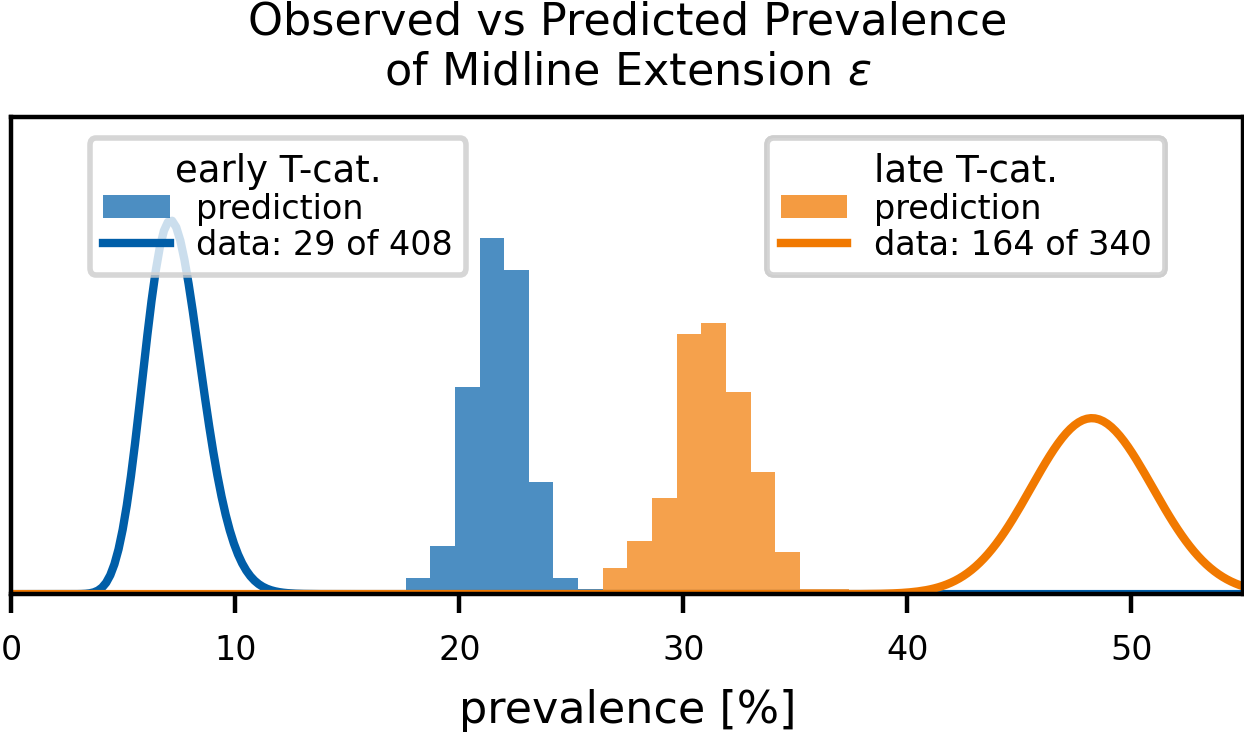
<figcaption>Figure 8: Comparing the predicted (histograms) and observed (lines depicting beta posteriors) prevalence of midline extension for early (blue) and late (orange) T-category. While the prevalence is predicted correctly when marginalizing over T-category, the model cannot capture the degree of separation observed in the data. Since the tumor’s midline extension is virtually always part of the diagnosis and hence <em>given</em> when predicting a patient’s risk, we do not consider this discrepancy a major issue.</figcaption>
</figure>

Lastly, in <a href="#fig-model-prevalences-midext" class="quarto-xref">figure 8</a>, we plot the prevalence of midline extension in the data versus our model’s prediction. It is obvious the model cannot match the large spread between early and advanced T-category seen in the data. This is because to achieve that, it would need to increase the advanced T-category patient’s prior distribution over diagnosis times and at the same time reduce the probability of the tumor to cross the midline during a time-step. But since the time-priors parameter is also coupled with the spread probabilities among the LNLs, the model does not have that freedom.

<!-- Should the paragraphs below be part of the discussion? -->

However, we do not consider this discrepancy a major limitation of the model: We will not realistically be interested in the probability of midline extension, as it is always possible to assess it with high certainty. That is also the reason why we initially modelled the midline extension *not* as a random variable, but as a global risk factor that would have been turned on or off from the onset of a patient’s disease evolution. This, however, lead to overly high risks for contralateral involvement in advanced T-category patients with midline extension, because then the model assumes an increased spread to the contralateral side from the onset of the disease. Which is probably not true in a majority of those cases. Thus, treating it as a random variable that only becomes true during a patient’s disease evolution resulted in a better description of the data.

Formally, the wrong prediction of midline extension prevalence makes little difference, since it is always given: Instead of $P\left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c}, \epsilon \mid \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c} \right)$, we typically compute $P\left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \mid \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c}, \epsilon \right)$, which does not suffer from the wrong probability of midline extension, as the distribution over hidden states is renormalized:

$$
P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c} \mid \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c}, \epsilon \right) = \frac{P \left( \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c} \mid \mathbf{X}^\text{i}, \mathbf{X}^\text{c}, \epsilon \right) P \left( \mathbf{X}^\text{i}, \mathbf{X}^\text{c}, \epsilon \right)}{P \left( \mathbf{Z}^\text{i}, \mathbf{Z}^\text{c}, \epsilon \right)}
$$

Note that a distribution over $\epsilon$ appears both in the enumerator and the denominator, which largely cancel each other, leaving only the midline extension’s effect on the distribution over hidden states in the prediction.

## Prediction of Risk for Occult Disease

In this section, we investigate how the model may be applied clinically: We want to estimate the risk for occult disease in some or all LNLs, given the patient’s individual diagnosis. In terms of our model, this diagnosis consists of the T-category, the lateralization of the tumor (does it extend over the mid-sagittal line?), and which LNLs are clinically involved, e.g. because some lymph nodes appear enlarged in an MRI scan or show increased glycolytic activity on an FDG PET/CT scan.

<figure id="fig-model-risks">
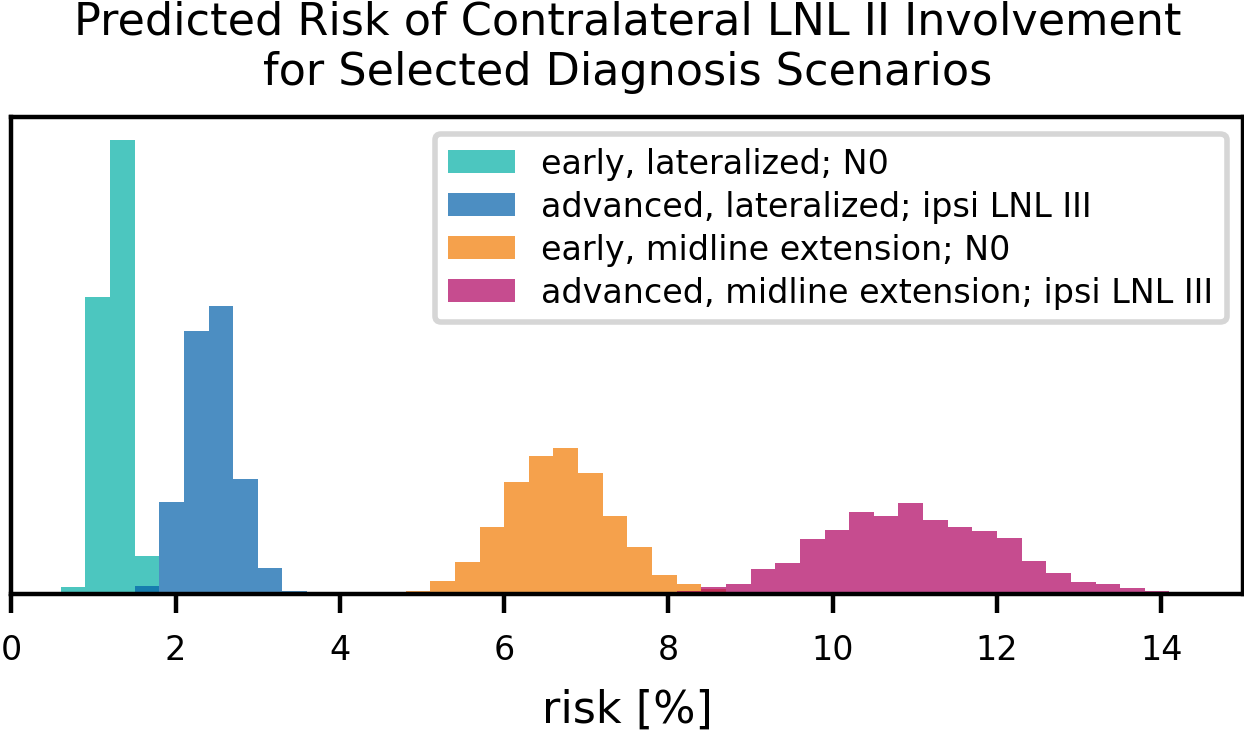
<figcaption>Figure 9: Histograms over the predicted risk of occult contralateral LNL II invovlement, shown for some combinations of T-category, tumor lateralization, and ipsilateral clinical involvement. The contralateral side was always assumed to be clinically negative.</figcaption>
</figure>

<a href="#fig-model-risks" class="quarto-xref">Figure 9</a> shows this predicted risk of occult disease in contralateral LNL II for four interesting combinations of these three risk factors. This risk is computed *given* a CT diagnosis assessing the per-LNL clinical involvement for which we assumed a sensitivity of 81% and a specificity of 76% ([De Bondt and Others 2007](#ref-debondt_detection_2007)).

The variable impacting the prediction for contralateral involvement in our model is the tumor’s lateralization. For example, a patient with a clearly lateralized early T-category tumor and a clinically N0 neck is assigned a 1-2% <!-- TODO: make this dynamic --> risk for occult disease in contralateral LNL II. Under the same scenario, but *with* mid-sagittal extension, the risk jumps to almost 7%. <!-- TODO: make this dynamic -->

T-category plays a lesser role: Considering the scenario of a tumor that crosses the mid-sagittal line and an ipsilateral neck where at least LNL III is clinically involved, the risk for occult contralateral LNL II disease is around 8.5%. <!-- TODO: make this dynamic --> For the same scenario and an advanced T-category tumor, the risk increases to 11%. <!-- TODO: make this dynamic -->

Lastly, the predicted risk is also correlated via the time-steps to the degree of ipsilateral involvement. Changing the aforementioned scenario (advanced T-category, midline extension, ipsilateral LNL III clinically involved) to one where the patient presents with a clinically N0 neck, the risk for occult disease in the contralateral LNL II falls from 11% <!-- TODO: make this dynamic --> to 9.5%. <!-- TODO: make this dynamic -->

Taken together, T-category and ipsilateral involvement may still considerably impact the risk prediction for contralateral involvement: In <a href="#fig-model-risks" class="quarto-xref">figure 9</a> the scenarios underlying the orange (6.5% <!-- TODO: make this dynamic -->) and the red (11% <!-- TODO: make this dynamic -->) histograms differ in T-category (early vs advanced) and clinical diagnosis (N0 vs ipsilateral at least LNL III involved).

# Discussion

-   conceptually extended model to cover both sides of neck
-   explicitly models midline extension (also allows for easy marginalization)
-   midline extension intuitively causes contralateral spread to become more similar to ipsilateral spread

# Acknowledgement

This work was supported by:

-   the Clinical Research Priority Program “Artificial Intelligence in Oncological Imaging” of the University of Zurich
-   the Swiss Cancer Research Foundation under grant number KFS 5645-08-2022

# Contralateral Prevalence of Involvement

In [6]:
lnl_cols = get_lnl_cols("contra", lnls=["I", "II", "III", "IV"])
num_ipsi_inv = raw[get_lnl_cols("ipsi")].sum(axis="columns")

contra_inv = raw[lnl_cols].copy()
contra_inv.columns = contra_inv.columns.droplevel([0,1])
contra_inv["t_stage"] = raw[COL.t_stage].apply(lambda x: "early" if x <= 2 else "advanced")
contra_inv["ipsi"] = num_ipsi_inv.map(lambda x: str(x) if x <= 1 else "≥ 2")
contra_inv["midext"] = raw[COL.midext]

grouped = contra_inv.groupby(by=["t_stage", "ipsi", "midext"])
num_involved = grouped.sum()
total = grouped.count()
percent_involved = num_involved / total
idx = total.index.rename(["T-cat.", "ipsi", "Mid. ext."])

total.index = idx
num_involved.index = idx
percent_involved.index = idx

involved = num_involved.join(
  100 * percent_involved,
  rsuffix=" (%)",
).sort_index(axis="columns")
involved.columns = pd.MultiIndex.from_product(
  [["I", "II", "III", "IV"],
   ["n", "%"]],
  names=["LNL", ""]
)
involved["total", "n"] = total["I"]
(
  involved
  .reset_index()
  .sort_values("ipsi", ascending=True)
  .sort_values("T-cat.", ascending=False)
  .style
  .format(precision=2)
  .apply(right_align, subset=involved.columns[0:])
  .apply(highlight_t_stage, subset=["T-cat."])
  .apply(highlight_bool, subset=["Mid. ext."])
  .apply(highlight, subset=["ipsi"], mapping={
    "0": COLORS["green"],
    "1": COLORS["orange"],
    "≥ 2": COLORS["red"],
  })
  .hide()
)

# Marginalizing Beta Posteriors over Unknowns

In [7]:
import pandas as pd
import numpy as np
from scripts import shared, COL

data = shared.get_data()
is_early = data[COL.t_stage].isin([0,1,2])

reduced = pd.DataFrame({
  "Midline Extension": data.loc[is_early, COL.midext],
  "contra LNL II": data.loc[is_early, ("max_llh", "contra", "II")]
})

result = (
  reduced
  .fillna("unknown")
  .value_counts(dropna=False)
  .unstack("Midline Extension")
  .rename(
    index={
      False: "healthy",
      True: "involved",
    },
    columns={
      False: "no",
      True: "yes",
    },
  )
)
result.loc["total"] = result.sum()
result

In <a href="#sec-prevalence" class="quarto-xref">section 5.3</a> we explained that we compare the predicted prevalence of an involvement pattern under a scenario to a beta posterior over the “true” prevalence given the observations in the data. However, our data contains incomplete observations, especially regarding the tumor’s midline extension. This information is not present for a large group of 85 patients, most of which treated at the Centre Léon Bérard in France.

To account for this missing information and plot the correct posteriors over the data prevalence, we need to marginalize over the possible combinations of matching involvement patterns and selected patients under a scenario. For example, we have only 29<!-- TODO: compute dynamically --> early T-category patients with midline extension. But for an additional 65<!-- TODO: compute dynamically --> patients we do not know whether the tumor crossed the mid-sagittal plane. If we now want to compute the prevalence of contralateral LNL II invovlement for these early T-category patients with midline extension, then we need to account for the possibility that we are missing information.

In <a href="#tbl-data-unknowns" class="quarto-xref">table 4</a> we show the combinations of the midline extension status and state of the contralateral LNL II. Using only available information, we would get to 6 out of 29<!-- TODO: compute dynamically --> patients for the prevalence of contralateral LNL II invovlement among the early T-category patients with midline extension. But the column with the “unknown” numbers suggests that the true prevalence could range from 6 out of 29 + 59 (7%)<!-- TODO: compute dynamically --> up to 12 out of 29 + 6 (34%)<!-- TODO: compute dynamically -->. We assume that every one of the possible combinations has the same a priori probability (uniform prior) but we do need to account for permutations via the binomial factor. In general, let us say we have $n$ patients with midline extension, of which $k$ harbor metastases in the contralateral LNL II. And we have $m$ patients with unknown midline extension, of which $\ell$ presented with diasease in contralateral LNL II, then the posterior distribution - marginalized over the unknown data - over the true prevalence $x \in \left[ 0, 1 \right]$ is given by:

$$
p(x \mid n, k, m, \ell, \alpha, \beta) = \left[ \frac{1}{m} \sum_{i=0}^m \frac{1}{\min(i,\ell)} \sum_{j=0}^{\min(i,\ell)} \frac{P(i, j \mid x )}{\binom{n}{k}} \right] \cdot P(n, k \mid x) \cdot \frac{1}{\operatorname{B}(\alpha, \beta)} x^\alpha (1-x)^\beta
$$

Note the two binomial likelihoods: one being marginalized over and one acting implicitly as a prior to the summed terms. This role of the likelihood over the data with known midline extension as a prior to the part where that data is missing corrects for the fact that there are highly unlikely combinations among those we marginalize over. E.g., expecting that exactly those 6 patients with contralateral LNL II involvemnt are also coincidentially the only ones of the 65 with a tumor crossing the mid-sagittal line is very unlikely. This is accounted for by the fact that this possibility has only one permutation and it is weakened by the likelihood over the data with known midline extension. With a uniform prior beta distribution ($\alpha=1$ and $\beta=1$), the above simplifies to:

$$
p(x \mid n, k, m, \ell) = \left[ \frac{1}{m} \sum_{i=0}^m \frac{1}{\min(i,\ell)} \sum_{j=0}^{\min(i,\ell)} \binom{n+i}{k+j} x^j (1 - x)^{i-j} \right] \cdot x^{k+1} (1 - x)^{n-k+1}
$$

We have plotted this marginal in <a href="#fig-model-marginal-pdf" class="quarto-xref">figure 10</a> (blue curve) and the terms that make up the above sum (light red curves). Note that we weighted the plotting opacity with the number of permutations each of the possible combinations has. The marginal is compared against the “naive” beta posterior that only takes the data into account for which midline extension is available (green curve).

<figure id="fig-model-marginal-pdf">
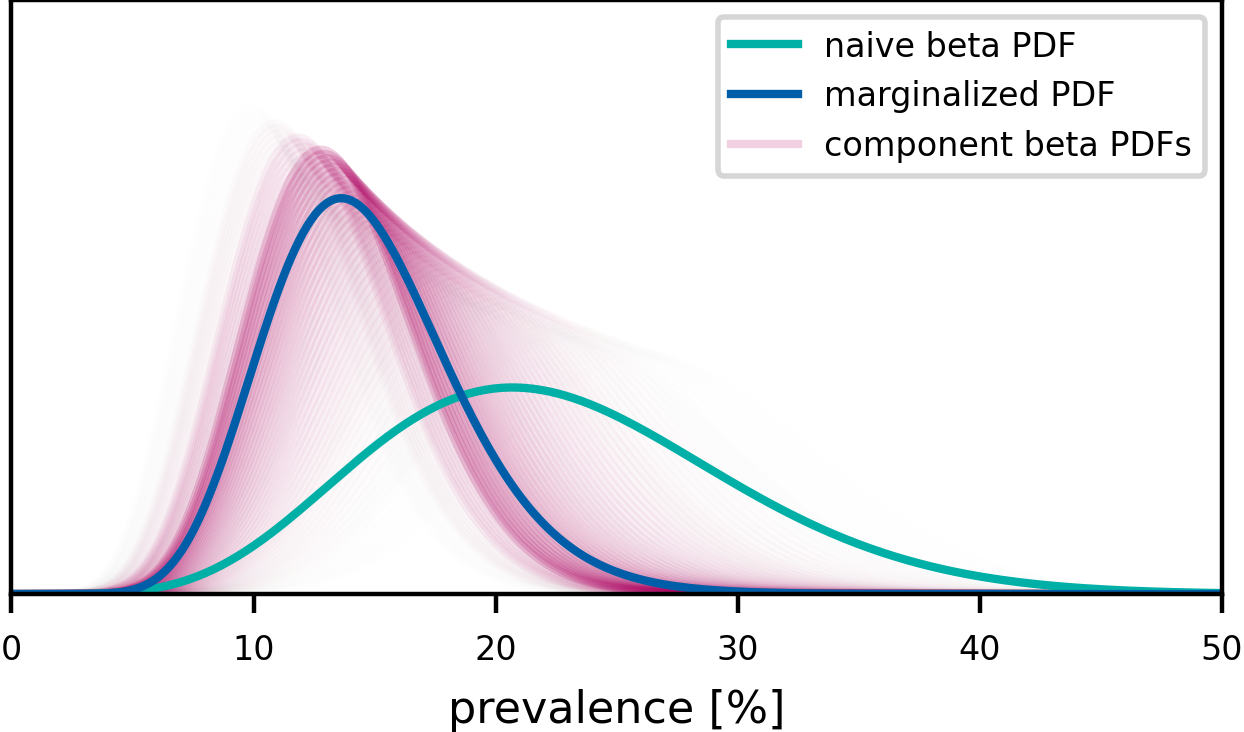
<figcaption>Figure 10: Posterior distributions over the data prevalence for contralateral LNL II involvement under the scenario of early T-category and midline extension. The green beta distribution shows this prevalence for those patients for which midline extension is known. While the blue PDF is a marginal distribution summed over all possible combinations, which are shown in shades of red. The more permutations a particular combination has, the more opaque it is plotted.</figcaption>
</figure>

The distribution that marginalizes over the unknown midline extension cases is shifted towards a lower prevalence. This makes intuitive sense: With only 6 patients among the 65 with unknown midline extension status, the upper bound for the prevalence has moved down compared to 6 out of 29.

We chose to compare our model against such corrected prevalence posteriors, because the model, too, is capable of marginalizing over unknown midline extension in the data. It would therefore be inaccurate to compare the model trained with the full dataset to only that part of the patient cohort where the tumor lateralization was recorded.

Biau, Julian, Michel Lapeyre, Idriss Troussier, Wilfried Budach, Jordi Giralt, Cai Grau, Joanna Kazmierska, et al. 2019. “Selection of Lymph Node Target Volumes for Definitive Head and Neck Radiation Therapy: A 2019 Update.” *Radiotherapy and Oncology* 134 (May): 1–9. <https://doi.org/10.1016/j.radonc.2019.01.018>.

Chao, K. S.Clifford, Franz J Wippold, Gokhan Ozyigit, Binh N Tran, and James F Dempsey. 2002. “Determination and Delineation of Nodal Target Volumes for Head-and-Neck Cancer Based on Patterns of Failure in Patients Receiving Definitive and Postoperative IMRT.” *International Journal of Radiation Oncology\*Biology\*Physics* 53 (5): 1174–84. <https://doi.org/10.1016/S0360-3016(02)02881-X>.

De Bondt, R, and Others. 2007. “Detection of Lymph Node Metastases in Head and Neck Cancer: A Meta-Analysis Comparing US, USgFNAC, CT and MR Imaging.” *Eur. J. Radiol.* 64: 266–72. <https://doi.org/10.1016/j.ejrad.2007.02.037>.

Eisbruch, Avraham, Robert L. Foote, Brian O’Sullivan, Jonathan J. Beitler, and Bhadrasain Vikram. 2002. “Intensity-Modulated Radiation Therapy for Head and Neck Cancer: Emphasis on the Selection and Delineation of the Targets.” *Seminars in Radiation Oncology* 12 (3): 238–49. <https://doi.org/10.1053/srao.2002.32435>.

Ferlito, Alfio, Carl E. Silver, and Alessandra Rinaldo. 2009. “Elective Management of the Neck in Oral Cavity Squamous Carcinoma: Current Concepts Supported by Prospective Studies.” *British Journal of Oral and Maxillofacial Surgery* 47 (1): 5–9. <https://doi.org/10.1016/j.bjoms.2008.06.001>.

Foreman-Mackey, Daniel, David W. Hogg, Dustin Lang, and Jonathan Goodman. 2013. “Emcee: The MCMC Hammer.” *\\Pasp* 125 (925): 306. <https://doi.org/10.1086/670067>.

Grégoire, Vincent, Kian Ang, Wilfried Budach, Cai Grau, Marc Hamoir, Johannes A. Langendijk, Anne Lee, et al. 2014. “Delineation of the Neck Node Levels for Head and Neck Tumors: A 2013 Update. DAHANCA, EORTC, HKNPCSG, NCIC CTG, NCRI, RTOG, TROG Consensus Guidelines.” *Radiotherapy and Oncology* 110 (1): 172–81. <https://doi.org/10.1016/j.radonc.2013.10.010>.

Grégoire, Vincent, Peter Levendag, Kian K. Ang, Jacques Bernier, Marijel Braaksma, Volker Budach, Cliff Chao, et al. 2003. “<span class="nocase">CT-based</span> Delineation of Lymph Node Levels and Related CTVs in the Node-Negative Neck: DAHANCA, EORTC, GORTEC, NCIC,RTOG Consensus Guidelines.” *Radiotherapy and Oncology* 69 (3): 227–36. <https://doi.org/10.1016/j.radonc.2003.09.011>.

Grégoire, V, and Others. 2018. “Delineation of the Primary Tumour Clinical Target Volumes (CTV-P) in Laryngeal, Hypopharyngeal, Oropharyngeal and Oral Cavity Squamous Cell Carcinoma: AIRO, CACA, DAHANCA, EORTC, GEORCC, GORTEC, HKNPCSG, HNCIG, IAG-KHT, LPRHHT, NCIC CTG, NCRI, NRG Oncology, PHNS, SBRT, SOMERA, SRO, SSHNO, TROG Consensus Guidelines.” *Radiother. Oncol.* 126: 3–24. <https://doi.org/10.1016/j.radonc.2017.10.016>.

Ludwig, Roman, Jean-Marc Hoffmann, Bertrand Pouymayou, Grégoire Morand, Martina Broglie Däppen, Matthias Guckenberger, Vincent Grégoire, Panagiotis Balermpas, and Jan Unkelbach. 2022. “A Dataset on Patient-Individual Lymph Node Involvement in Oropharyngeal Squamous Cell Carcinoma.” *Data in Brief* 43 (August): 108345. <https://doi.org/10.1016/j.dib.2022.108345>.

Ludwig, Roman, Bertrand Pouymayou, Panagiotis Balermpas, and Jan Unkelbach. 2021. “A Hidden Markov Model for Lymphatic Tumor Progression in the Head and Neck.” *Sci Rep* 11 (1): 12261. <https://doi.org/10.1038/s41598-021-91544-1>.

Ludwig, Roman, Adrian Schubert, Dorothea Barbatei, Lauence Bauwens, Jean-Marc Hoffmann, Sandrine Werlen, Olgun Elicin, et al. 2023. “Modelling the Lymphatic Metastatic Progression Pathways of OPSCC from Multi-Institutional Datasets.” *arXiv.org*. https://arxiv.org/abs/2312.11270v3.

Ludwig, Roman, Adrian Schubert, Dorothea Barbatei, Laurence Bauwens, Sandrine Werlen, Olgun Elicin, Matthias Dettmer, et al. 2023. “A Multi-Centric Dataset on Patient-Individual Pathological Lymph Node Involvement in Head and Neck Squamous Cell Carcinoma.” *Data in Brief*, December, 110020. <https://doi.org/10.1016/j.dib.2023.110020>.

Pouymayou, Bertrand, Panagiotis Balermpas, Oliver Riesterer, Matthias Guckenberger, and Jan Unkelbach. 2019. “A Bayesian Network Model of Lymphatic Tumor Progression for Personalized Elective CTV Definition in Head and Neck Cancers.” *Physics in Medicine & Biology* 64 (16): 165003. <https://doi.org/10.1088/1361-6560/ab2a18>.

Vorwerk, Hilke, and Clemens F. Hess. 2011. “Guidelines for Delineation of Lymphatic Clinical Target Volumes for High Conformal Radiotherapy: Head and Neck Region.” *Radiation Oncology* 6 (1): 97. <https://doi.org/10.1186/1748-717X-6-97>.